In [1]:
import numpy as np
import pandas as pd
import time
import os
import re

In [2]:
import math

def make_batches_from_dataset(df, batch_size):
    num_batch = math.ceil(df.shape[0] / batch_size)
    df_batches = []
    start_index = 0
    for i in range(num_batch):
        df_batches.append(df[start_index : start_index + batch_size])
        start_index = start_index + batch_size
    return df_batches

In [2]:
def get_last_index(indexfilepath):
    last_idx = 0
    # read from file
    try:
        last_idx = pd.read_csv(indexfilepath)
        last_idx = last_idx.values[0][0]
    except FileNotFoundError as fnfe:
        last_idx = 0
    return last_idx

In [4]:
def save_data_till_last_iteration(df, filepath, indexfilepath):
    df.to_csv(filepath, index=False)
    global last_idx
    pd.Series(data=[last_idx]).to_csv(indexfilepath, index=False)

In [3]:
def is_file_exist(filedir, filename):
    file_exist = False
    #for _, _, filenames in os.walk('/kaggle/working'):
    for _, _, filenames in os.walk(filedir):
        if filename in filenames:
            file_exist = True
            break
    return file_exist

In [6]:
def iter_cot_bootstrapping_module(bootstrapping_limit):
    correct_answer = strategyqa[1]["answer"]
    print(f"Index: {strategyqa[0]}")
    str_correct_answer = ""
    if correct_answer == True:
        str_correct_answer = "yes"
    if correct_answer == False:
        str_correct_answer = "no"
    model_answer = ""
    final_answer = ""
    cot_answer_attempt = 0
    while final_answer != str_correct_answer:
        if cot_answer_attempt == bootstrapping_limit:
            break
        if cot_answer_attempt == 0:
            PROMPT = f"""Act as a Strategic Reasoning Expert. You have knowledge to answer questions using the reasoning steps which should be inferred using strategy.
Your task is to think deeply, step by step and answer the given question using step by step reasoning approach. Your final answer always derives from your reasoning paragraph.

I am going to provide a template for your output. <placeholder> are my placeholders for content. Try to fit the output into one or more of the placeholders that I list. \
Please preserve the formatting and overall template that I provide.

This is the template:
A: Reasoning: <small reasoning paragraph> Final Answer: <final answer as yes or no>

Q: {strategyqa[1]["term"]}, {strategyqa[1]["description"]}, {strategyqa[1]["question"]}
A:"""
        else:
            if final_answer == "unknown":
                PROMPT = f"""{model_answer}

According to the above template, the final answer is missing in your previous output. So, give me the final answer of the following question correctly. Please add final answer after the reasoning paragraph.

Q: {strategyqa[1]["term"]}, {strategyqa[1]["description"]}, {strategyqa[1]["question"]}
A:"""
            else:
                PROMPT = f"""{model_answer}

Your above reasoning and final answer are not correct. You please again think deeply and step by step. After that, you please do not repeat previous reasoning, change your previous reasoning and final answer. \
Then again give me the new reasoning and final answer of the following question correctly.

Moreover, according to the above template, either reasoning or final answer is missing in your previous output. Please add final answer after the reasoning paragraph.

Q: {strategyqa[1]["term"]}, {strategyqa[1]["description"]}, {strategyqa[1]["question"]}
A:"""
        
        inputs = tokenizer(
            PROMPT,
            return_tensors="pt",
        )
        input_ids = inputs["input_ids"].to('cuda:0')
        generation_config = GenerationConfig(
            temperature=0.5,
            top_p=0.95,
            repetition_penalty=1.15,
        )
        print("Generating...")
        output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=1024,#128
        )
        model_answer = tokenizer.decode(output.sequences[0])
        print(model_answer)
        print("---------------------------------------------------")
        final_answer = model_answer.lower()
        try:
            if final_answer.rfind("final answer: ") == -1:
                if final_answer[-3:] == "yes":
                    final_answer = "yes"
                elif final_answer[-2:] == "no":
                    final_answer = "no"
                else:
                    final_answer = final_answer.rsplit(" ", 1)[1]
                    if re.search(r"yes", final_answer) != None:
                        final_answer = "yes"
                    elif re.search(r"no", final_answer) != None:
                        final_answer = "no"
                    else:
                        final_answer = "unknown"
            else:
                final_answer = final_answer[final_answer.rfind("final answer: ") + 14:]
                if final_answer.startswith("yes"):
                    final_answer = "yes"
                elif final_answer.startswith("no"):
                    final_answer = "no"
                else:
                    if final_answer[-3:] == "yes":
                        final_answer = "yes"
                    elif final_answer[-2:] == "no":
                        final_answer = "no"
                    else:
                        final_answer = final_answer.rsplit(" ", 1)[1]
                        if re.search(r"yes", final_answer) != None:
                            final_answer = "yes"
                        elif re.search(r"no", final_answer) != None:
                            final_answer = "no"
                        else:
                            final_answer = "unknown"
        except Exception as e:
            print(e)
            final_answer = "unknown"
        print(final_answer)
        print("------------------------------------")
        cot_answer_attempt = cot_answer_attempt + 1
    if cot_answer_attempt < bootstrapping_limit:
        iter_cot_answer = model_answer[model_answer.rfind("A:"):]
        if iter_cot_answer.lower().rfind("final answer: ") == -1:
            iter_cot_answer = iter_cot_answer + f" Final Answer: {final_answer}"
        iter_cot_answer = iter_cot_answer.replace("<s>", "").replace("</s>", "")
        print("------Modified-----------")
        print(iter_cot_answer)
        print("----------------------")
        print(final_answer)
        print("---------------------------")
        df_strategyqa_train.loc[strategyqa[0], "iter-cot-answer"] = iter_cot_answer
        df_strategyqa_train.loc[strategyqa[0], "final-answer"] = final_answer
        df_strategyqa_train.loc[strategyqa[0], "iter-cot-answer-tokens-length"] = len(tokenizer.encode(iter_cot_answer))
        df_strategyqa_train.loc[strategyqa[0], "num-iteration-to-correct"] = cot_answer_attempt - 1
    print(f"Iteration: {cot_answer_attempt - 1}")
    print("------------------------------------------------------------")

In [7]:
def iter_cot_inference_module(trial_no, num_batch, few_shots_exemplars, idx, question, answer):
    for i in range(len(few_shots_exemplars) + 1):
        if i == 0:
            PROMPT = f"""{iter_cot_few_shots_prompt}

Q: {question}
A:"""
        else:
            fsp = iter_cot_few_shots_prompt + "\n\n" + "\n\n".join(few_shots_exemplars[:i])
            PROMPT = f"""{fsp}

Q: {question}
A:"""

        model_answer = ""

        inputs = tokenizer(
            PROMPT,
            return_tensors="pt",
        )
        input_ids = inputs["input_ids"].to('cuda:0')
        generation_config = GenerationConfig(
            temperature=0,
            top_p=0.95,
            repetition_penalty=1.15,
        )
        print("Generating...")
        output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=1024, #128
        )
        model_answer = tokenizer.decode(output.sequences[0])
        print(f"trail no : {trial_no}, batch number : {num_batch}, index : {idx}")
        print("------------------------------------------")
        print(model_answer)
        print("---------------------------------------------------")
        final_answer = model_answer.lower()
        try:
            if final_answer.rfind("final answer: ") == -1:
                if final_answer[-3:] == "yes":
                    final_answer = "yes"
                elif final_answer[-2:] == "no":
                    final_answer = "no"
                else:
                    final_answer = final_answer.rsplit(" ", 1)[1]
                    if re.search(r"yes", final_answer) != None:
                        final_answer = "yes"
                    elif re.search(r"no", final_answer) != None:
                        final_answer = "no"
                    else:
                        final_answer = "unknown"
            else:
                final_answer = final_answer[final_answer.rfind("final answer: ") + 14:]
                if final_answer.startswith("yes"):
                    final_answer = "yes"
                elif final_answer.startswith("no"):
                    final_answer = "no"
                else:
                    if final_answer[-3:] == "yes":
                        final_answer = "yes"
                    elif final_answer[-2:] == "no":
                        final_answer = "no"
                    else:
                        final_answer = final_answer.rsplit(" ", 1)[1]
                        if re.search(r"yes", final_answer) != None:
                            final_answer = "yes"
                        elif re.search(r"no", final_answer) != None:
                            final_answer = "no"
                        else:
                            final_answer = "unknown"
        except Exception as e:
            print(e)
            final_answer = "unknown"    
        print(final_answer)
        print("------------------------------------")
        df_strategyqa_eval.loc[idx, f"""trial-{trial_no}-iter-cot-answer-{i}"""] = model_answer[model_answer.rfind("A:"):]
        if final_answer == "yes" and answer == True:
            df_strategyqa_eval.loc[idx, f"""trial-{trial_no}-iter-cot-answer-{i}-correct"""] = True
        if final_answer == "no" and answer == False:
            df_strategyqa_eval.loc[idx, f"""trial-{trial_no}-iter-cot-answer-{i}-correct"""] = True

In [8]:
!pip install -U accelerate peft transformers bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 59.9 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 12.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 80.7 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.3
    Uninstalling accelerate-0.20.3:
      Successfully uninstalled accelerate-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.2
    Uninstalling transformers-4.30.2:
      Successfully uninstalled transformers-4.30.2


In [151]:
from peft import PeftModel, PeftConfig
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig

#is_peft = True
#is_peft = False

#model_id = "chansung/alpaca-lora-13b"
#model_id = "chansung/alpaca-lora-30b"

#model_id = "lmsys/vicuna-13b-v1.5-16k"

model_id = "TheBloke/wizardLM-13B-1.0-fp16"

#llm_name = "alpaca-lora-13b"
#llm_name = "alpaca-lora-30b"

#llm_name = "vicuna-13b-v1.5-16k"

llm_name = "wizardLM-13B-1.0-fp16"

In [10]:
if is_peft == True:
    config = PeftConfig.from_pretrained(model_id)
    print(config.base_model_name_or_path)
    peft_model_id = model_id
    model_id = config.base_model_name_or_path

In [11]:
model = LlamaForCausalLM.from_pretrained(model_id, 
                                        low_cpu_mem_usage=True, 
                                        device_map="auto",
                                        load_in_4bit=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
if is_peft == True:
    model = PeftModel.from_pretrained(model, peft_model_id)

In [13]:
tokenizer = LlamaTokenizer.from_pretrained(model_id)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [18]:
df_strategyqa_train = pd.read_json("/kaggle/input/strategyqa-dataset-for-thesis/strategyqa_train.json")
df_strategyqa_train

,qid,term,description,question,answer,facts,decomposition,evidence
0,b8677742616fef051f00,Genghis Khan,founder and first Great Khan of the Mongol Empire,Are more people today related to Genghis Khan ...,True,"[Julius Caesar had three children., Genghis Kh...","[How many kids did Julius Caesar have?, How ma...","[[[['Caesarion-2', 'Julia (daughter of Caesar)..."
1,4668264df84fb7c25b39,The Police,English rock band,Could the members of The Police perform lawful...,False,"[The members of The Police were musicians, not...","[Who can perform lawful arrests?, Are members ...","[[[['Arrest-2']], [[""Citizen's arrest-2"", 'The..."
2,41450dbd623437269f8f,Depression (mood),state of low mood and fatigue,Would a Monoamine Oxidase candy bar cheer up a...,False,[Depression is caused by low levels of seroton...,[Depression is caused by low levels of what ch...,"[[[['Monoamine oxidase-8']], [['Monoamine oxid..."
3,7419826e4373eb1e83ff,Grey seal,species of seal,Would a dog respond to bell before Grey seal?,True,[Grey seals have no ear flaps and their ears c...,[How sensitive is a grey seal's hearing on lan...,"[[[['Pinniped-24']], [['Hearing range-11', 'He..."
4,1b29d402c3e17cb3b435,Pound sterling,Official currency of the United Kingdom and ot...,Is a pound sterling valuable?,False,"[A pound sterling is fiat money., Fiat money i...",[What is the value of the Pound Sterling based...,"[[[['Pound sterling-16']], [['Pound sterling-1..."
...,...,...,...,...,...,...,...,...
2285,a0c8f44c4b3ad35df66e,Catfish,order of fishes,Is a cory catfish likely to eat another living...,False,[The cory catfish is a fish that is described ...,"[What do cory catfish eat?, Is fish part of #1?]","[[[['Corydoras-5']], [['Corydoras-5'], operati..."
2286,2079d6c0fea33860fbc3,Achilles,Greek mythological hero,Does Thiago Moises May 13 2020 submission move...,True,[Thiago Moises is a mixed martial arts fighter...,[ What was Thiago Moises' winning move the mat...,"[[[no_evidence], [no_evidence], [['Achilles-2'..."
2287,60fe2d35b5abf0f0652a,Alec Baldwin,"American actor, writer, producer, and comedian",Does Alec Baldwin have more children than Clin...,False,"[Alec Baldwin has 5 children as of 2020., Acto...",[How many children does Alec Baldwin presently...,"[[[['Alec Baldwin-42', 'Alec Baldwin-47']], [[..."
2288,8c599ce83178d5c0f480,Prime Minister of the United Kingdom,Head of UK Government,Does highest US Court have enough seats for ev...,False,[The highest court in the US is the Supreme Co...,"[What is the highest United States court?, How...","[[[['Supreme Court of the United States-1']], ..."


In [13]:
df_strategyqa_train.dtypes

qid              object
term             object
description      object
question         object
answer             bool
facts            object
decomposition    object
evidence         object
dtype: object

In [17]:
!pip install -U ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 6.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: ydata-profiling
    Found existing installation: ydata-profiling 4.3.1
    Uninstalling ydata-profiling-4.3.1:
      Successfully uninstalled ydata-profiling-4.3.1


In [17]:
from ydata_profiling import ProfileReport

data_profile_config_path = "/kaggle/input/data-profile/bht_thesis_config_1.yaml"
strategyqa_data_profile_path = "/kaggle/working/df_strategyqa_train_report_v1.html"
profile = ProfileReport(df_strategyqa_train, title="StrategyQA Train Data Profiling Report v1", config_file=data_profile_config_path)
profile.to_file(strategyqa_data_profile_path)

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
#file_name = "strategyqa-train-with-alpaca-13B-ans.csv"
#file_name = "strategyqa-train-with-alpaca-30B-ans.csv"

#file_name = "strategyqa-train-with-vicuna-13b-v1.5-16k-ans.csv"

file_name = "strategyqa-train-with-wizardLM-13B-ans.csv"

In [16]:
#filedir = "/kaggle/working"
filedir = "/kaggle/input/strategyqa-train-dataset-with-llms"

In [17]:
file_exist = is_file_exist(filedir, file_name)
file_exist

True

In [18]:
filepath = f"{filedir}/{file_name}"

In [19]:
if file_exist == True:
    df_strategyqa_train = pd.read_csv(filepath)
else:
    default_ans = (['na' for i in range(df_strategyqa_train.shape[0])], [-1 for i in range(df_strategyqa_train.shape[0])])
    df_strategyqa_train.insert(df_strategyqa_train.shape[1], "iter-cot-answer", default_ans[0])
    df_strategyqa_train.insert(df_strategyqa_train.shape[1], "final-answer", default_ans[0])
    df_strategyqa_train.insert(df_strategyqa_train.shape[1], "iter-cot-answer-tokens-length", default_ans[1])
    df_strategyqa_train.insert(df_strategyqa_train.shape[1], "num-iteration-to-correct", default_ans[1])
df_strategyqa_train

,qid,term,description,question,answer,facts,decomposition,evidence,iter-cot-answer,final-answer,iter-cot-answer-tokens-length,num-iteration-to-correct
0,b8677742616fef051f00,Genghis Khan,founder and first Great Khan of the Mongol Empire,Are more people today related to Genghis Khan ...,True,"['Julius Caesar had three children.', 'Genghis...","['How many kids did Julius Caesar have?', 'How...","[[[['Caesarion-2', 'Julia (daughter of Caesar)...",A: Reasoning: \nGenghis Khan had many children...,yes,158,1
1,4668264df84fb7c25b39,The Police,English rock band,Could the members of The Police perform lawful...,False,"['The members of The Police were musicians, no...","['Who can perform lawful arrests?', 'Are membe...","[[[['Arrest-2']], [[""Citizen's arrest-2"", 'The...",A: Reasoning: \nThe members of The Police were...,no,134,1
2,41450dbd623437269f8f,Depression (mood),state of low mood and fatigue,Would a Monoamine Oxidase candy bar cheer up a...,False,['Depression is caused by low levels of seroto...,['Depression is caused by low levels of what c...,"[[[['Monoamine oxidase-8']], [['Monoamine oxid...",A: Reasoning: It's important to note that ther...,no,144,1
3,7419826e4373eb1e83ff,Grey seal,species of seal,Would a dog respond to bell before Grey seal?,True,['Grey seals have no ear flaps and their ears ...,"[""How sensitive is a grey seal's hearing on la...","[[[['Pinniped-24']], [['Hearing range-11', 'He...",na,na,-1,-1
4,1b29d402c3e17cb3b435,Pound sterling,Official currency of the United Kingdom and ot...,Is a pound sterling valuable?,False,"['A pound sterling is fiat money.', 'Fiat mone...",['What is the value of the Pound Sterling base...,"[[[['Pound sterling-16']], [['Pound sterling-1...",A: Reasoning: The value of a currency depends ...,no,164,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2285,a0c8f44c4b3ad35df66e,Catfish,order of fishes,Is a cory catfish likely to eat another living...,False,['The cory catfish is a fish that is described...,"['What do cory catfish eat?', 'Is fish part of...","[[[['Corydoras-5']], [['Corydoras-5'], 'operat...",na,na,-1,-1
2286,2079d6c0fea33860fbc3,Achilles,Greek mythological hero,Does Thiago Moises May 13 2020 submission move...,True,['Thiago Moises is a mixed martial arts fighte...,"["" What was Thiago Moises' winning move the ma...","[[['no_evidence'], ['no_evidence'], [['Achille...",na,na,-1,-1
2287,60fe2d35b5abf0f0652a,Alec Baldwin,"American actor, writer, producer, and comedian",Does Alec Baldwin have more children than Clin...,False,"['Alec Baldwin has 5 children as of 2020.', 'A...",['How many children does Alec Baldwin presentl...,"[[[['Alec Baldwin-42', 'Alec Baldwin-47']], [[...",na,na,-1,-1
2288,8c599ce83178d5c0f480,Prime Minister of the United Kingdom,Head of UK Government,Does highest US Court have enough seats for ev...,False,['The highest court in the US is the Supreme C...,"['What is the highest United States court?', '...","[[[['Supreme Court of the United States-1']], ...",na,na,-1,-1


In [22]:
df_strategyqa_train.dtypes

qid                              object
term                             object
description                      object
question                         object
answer                             bool
facts                            object
decomposition                    object
evidence                         object
iter-cot-answer                  object
final-answer                     object
iter-cot-answer-tokens-length     int64
num-iteration-to-correct          int64
dtype: object

In [41]:
import gc
import torch

gc.collect()

torch.cuda.empty_cache()

In [20]:
#index_file_name = "strategyqa-train-with-alpaca-13B-last-idx.csv"
#index_file_name = "strategyqa-train-with-alpaca-30B-last-idx.csv"

#index_file_name = "strategyqa-train-with-vicuna-13b-v1.5-16k-last-idx.csv"

index_file_name = "strategyqa-train-with-wizardLM-13B-last-idx.csv"

In [21]:
#filedir = "/kaggle/working"
filedir = "/kaggle/input/strategyqa-train-dataset-with-llms"

In [22]:
indexfilepath = f"{filedir}/{index_file_name}"

In [23]:
last_idx = get_last_index(indexfilepath)
last_idx

179

In [24]:
batch_size = 50
df_strategyqa_train_batches = make_batches_from_dataset(df_strategyqa_train[last_idx:], batch_size)

In [25]:
#file_name = "strategyqa-train-with-alpaca-13B-ans.csv"
#index_file_name = "strategyqa-train-with-alpaca-13B-last-idx.csv"

#file_name = "strategyqa-train-with-alpaca-30B-ans.csv"
#index_file_name = "strategyqa-train-with-alpaca-30B-last-idx.csv"

#file_name = "strategyqa-train-with-vicuna-13b-v1.5-16k-ans.csv"
#index_file_name = "strategyqa-train-with-vicuna-13b-v1.5-16k-last-idx.csv"

file_name = "strategyqa-train-with-wizardLM-13B-ans.csv"
index_file_name = "strategyqa-train-with-wizardLM-13B-last-idx.csv"

In [26]:
filedir = "/kaggle/working"
#filedir = "/kaggle/input/strategyqa-train-dataset-with-llms"

In [27]:
filepath = f"{filedir}/{file_name}"
indexfilepath = f"{filedir}/{index_file_name}"

In [28]:
bootstrapping_limit = 5

In [ ]:
batch_count = 1
got_exception = False
for df_strategyqa_train_batch in df_strategyqa_train_batches:
    print(f"Batch: {batch_count}")
    print("-----------------------------")
    for strategyqa in df_strategyqa_train_batch.iterrows():
        try:
            iter_cot_bootstrapping_module(bootstrapping_limit)
        except Exception as exp:
            # print message
            print(exp)
            # save data till previous iteration
            if last_idx != 0:
                save_data_till_last_iteration(df_strategyqa_train, filepath, indexfilepath)
            got_exception = True
            break
        last_idx = last_idx + 1
    if got_exception == True:
        break
    save_data_till_last_iteration(df_strategyqa_train, filepath, indexfilepath)
    batch_count = batch_count + 1
    time.sleep(60)

Batch: 1
-----------------------------
Index: 179
Generating...


/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configurati

<s> Act as a Strategic Reasoning Expert. You have knowledge to answer questions using the reasoning steps which should be inferred using strategy.
Your task is to think deeply, step by step and answer the given question using step by step reasoning approach. Your final answer always derives from your reasoning paragraph.

I am going to provide a template for your output. <placeholder> are my placeholders for content. Try to fit the output into one or more of the placeholders that I list. Please preserve the formatting and overall template that I provide.

This is the template:
A: Reasoning: <small reasoning paragraph> Final Answer: <final answer as yes or no>

Q: Indian Ocean, The ocean between Africa, Asia, Australia and Antarctica (or the Southern Ocean), Has the Indian Ocean garbage patch not completed two full rotations of debris since its discovery?
A: Reasoning: 
The Indian Ocean Garbage Patch was first discovered in 2010, and it has been reported that it has not completed two fu

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configurati

<s><s>  Act as a Strategic Reasoning Expert. You have knowledge to answer questions using the reasoning steps which should be inferred using strategy.
Your task is to think deeply, step by step and answer the given question using step by step reasoning approach. Your final answer always derives from your reasoning paragraph.

I am going to provide a template for your output. <placeholder> are my placeholders for content. Try to fit the output into one or more of the placeholders that I list. Please preserve the formatting and overall template that I provide.

This is the template:
A: Reasoning: <small reasoning paragraph> Final Answer: <final answer as yes or no>

Q: Indian Ocean, The ocean between Africa, Asia, Australia and Antarctica (or the Southern Ocean), Has the Indian Ocean garbage patch not completed two full rotations of debris since its discovery?
A: Reasoning: 
The Indian Ocean Garbage Patch was first discovered in 2010, and it has been reported that it has not completed tw

In [34]:
#file_name = "strategyqa-train-with-alpaca-13B-ans.csv"
#index_file_name = "strategyqa-train-with-alpaca-13B-last-idx.csv"

#file_name = "strategyqa-train-with-alpaca-30B-ans.csv"
#index_file_name = "strategyqa-train-with-alpaca-30B-last-idx.csv"

file_name = "strategyqa-train-with-vicuna-13b-v1.5-16k-ans.csv"
index_file_name = "strategyqa-train-with-vicuna-13b-v1.5-16k-last-idx.csv"

#file_name = "strategyqa-train-with-wizardLM-13B-ans.csv"
#index_file_name = "strategyqa-train-with-wizardLM-13B-last-idx.csv"

In [35]:
filedir = "/kaggle/working"
#filedir = "/kaggle/input/strategyqa-train-dataset-with-llms"

In [36]:
filepath = f"{filedir}/{file_name}"
indexfilepath = f"{filedir}/{index_file_name}"

In [37]:
save_data_till_last_iteration(df_strategyqa_train, filepath, indexfilepath)

In [ ]:
# K-iter Demonstrations Pools

In [78]:
#file_name = "strategyqa-train-with-alpaca-13B-ans.csv"
# temporary because of batches and code completion
#index_file_name = "strategyqa-train-with-alpaca-13B-last-idx.csv"

#file_name = "strategyqa-train-with-alpaca-30B-ans.csv"
# temporary because of batches and code completion
#index_file_name = "strategyqa-train-with-alpaca-30B-last-idx.csv"

#file_name = "strategyqa-train-with-vicuna-13b-v1.5-16k-ans.csv"
# temporary because of batches and code completion
#index_file_name = "strategyqa-train-with-vicuna-13b-v1.5-16k-last-idx.csv"

file_name = "strategyqa-train-with-wizardLM-13B-ans.csv"
# temporary because of batches and code completion
index_file_name = "strategyqa-train-with-wizardLM-13B-last-idx.csv"

In [79]:
#filedir = "/kaggle/working"
filedir = "/kaggle/input/strategyqa-train-dataset-with-llms"

In [80]:
filepath = f"{filedir}/{file_name}"
indexfilepath = f"{filedir}/{index_file_name}"

In [81]:
llm_name

'wizardLM-13B-1.0-fp16'

In [82]:
#df_strategyqa_train = pd.read_csv(f"/kaggle/working/{file_name}")
df_strategyqa_train = pd.read_csv(filepath)

# temprary because of batches and code completion
#last_idx = get_last_index(f"/kaggle/working/{index_file_name}")
last_idx = get_last_index(indexfilepath)
print(last_idx)

df_strategyqa_train_group_by = df_strategyqa_train[:last_idx][["final-answer", "iter-cot-answer-tokens-length", "num-iteration-to-correct"]].groupby(by=["num-iteration-to-correct"])
final_answer_count = df_strategyqa_train_group_by["final-answer"].count()
df_strategyqa_train_performance = pd.DataFrame({
    "dataset-name": ["StrategyQA" for val in final_answer_count.index.values],
    "model-name": [llm_name for val in final_answer_count.index.values],
    "num-iteration-to-correct": final_answer_count.index.values,
    "final-answer": final_answer_count.to_list(),
    "answer-tokens-max-length": df_strategyqa_train_group_by["iter-cot-answer-tokens-length"].max().to_list(),
    "answer-tokens-average-length": df_strategyqa_train_group_by["iter-cot-answer-tokens-length"].mean().to_list()
})
df_strategyqa_train_performance

201


,dataset-name,model-name,num-iteration-to-correct,final-answer,answer-tokens-max-length,answer-tokens-average-length
0,StrategyQA,wizardLM-13B-1.0-fp16,-1,37,-1,-1.000000
1,StrategyQA,wizardLM-13B-1.0-fp16,0,49,209,107.448980
2,StrategyQA,wizardLM-13B-1.0-fp16,1,76,382,141.855263
3,StrategyQA,wizardLM-13B-1.0-fp16,2,32,296,181.500000
4,StrategyQA,wizardLM-13B-1.0-fp16,3,7,342,189.428571


In [ ]:
# final-answer = corrected examples from iteration 1
# accuracy = (correct examples / total examples) * 100

In [83]:
# temporary because of batches and code completion
#index_file_name = "strategyqa-train-with-alpaca-13B-last-idx.csv"
#index_file_name = "strategyqa-train-with-alpaca-30B-last-idx.csv"
#index_file_name = "strategyqa-train-with-vicuna-13b-v1.5-16k-last-idx.csv"
index_file_name = "strategyqa-train-with-wizardLM-13B-last-idx.csv"

In [84]:
#filedir = "/kaggle/working"
filedir = "/kaggle/input/strategyqa-train-dataset-with-llms"

In [85]:
indexfilepath = f"{filedir}/{index_file_name}"

In [ ]:
index_file_name = "strategyqa-train-with-alpaca-13B-last-idx.csv"

In [86]:
# temprary because of batches and code completion
# todo: it will be total record size which is shape[0]
#last_idx = get_last_index(f"/kaggle/working/{index_file_name}")
last_idx = get_last_index(indexfilepath)
#num_record = df_strategyqa_train.shape[0]
num_record = last_idx
print(last_idx)

default_ans = ([0 for i in range(df_strategyqa_train_performance.shape[0])], [0.0 for i in range(df_strategyqa_train_performance.shape[0])])
df_strategyqa_train_performance.insert(df_strategyqa_train_performance.shape[1], "correct-answer", default_ans[0])
df_strategyqa_train_performance.insert(df_strategyqa_train_performance.shape[1], "ratio-correct-incorrect", default_ans[1])
df_strategyqa_train_performance.insert(df_strategyqa_train_performance.shape[1], "accuracy", default_ans[1])
for strategyqa_train_performance in df_strategyqa_train_performance[1:].iterrows():
    # batch size will be total number of rows in train set
    if strategyqa_train_performance[1]["num-iteration-to-correct"] == 0:
        correct_answer = strategyqa_train_performance[1]["final-answer"]
    else:
        corrected_answer = strategyqa_train_performance[1]["final-answer"]
        correct_answer = correct_answer + corrected_answer
    incorrect_answer = num_record - correct_answer
    df_strategyqa_train_performance.loc[strategyqa_train_performance[0], "correct-answer"] = correct_answer
    if incorrect_answer != 0.0:
        df_strategyqa_train_performance.loc[strategyqa_train_performance[0], "ratio-correct-incorrect"] = float(correct_answer) / float(incorrect_answer)
    df_strategyqa_train_performance.loc[strategyqa_train_performance[0], "accuracy"] = (float(correct_answer) / float(num_record)) * 100.00
df_strategyqa_train_performance

201


,dataset-name,model-name,num-iteration-to-correct,final-answer,answer-tokens-max-length,answer-tokens-average-length,correct-answer,ratio-correct-incorrect,accuracy
0,StrategyQA,wizardLM-13B-1.0-fp16,-1,37,-1,-1.000000,0,0.000000,0.000000
1,StrategyQA,wizardLM-13B-1.0-fp16,0,49,209,107.448980,49,0.322368,24.378109
2,StrategyQA,wizardLM-13B-1.0-fp16,1,76,382,141.855263,125,1.644737,62.189055
3,StrategyQA,wizardLM-13B-1.0-fp16,2,32,296,181.500000,157,3.568182,78.109453
4,StrategyQA,wizardLM-13B-1.0-fp16,3,7,342,189.428571,164,4.432432,81.592040


In [25]:
df_strategyqa_train_performance.dtypes

dataset-name                     object
model-name                       object
num-iteration-to-correct          int64
final-answer                      int64
answer-tokens-max-length          int64
answer-tokens-average-length    float64
correct-answer                    int64
ratio-correct-incorrect         float64
accuracy                        float64
dtype: object

In [ ]:
# confirm whether iter-cot-bootstrapping-performance.csv will read from working or input directory

In [87]:
filedir =  "/kaggle/working"
#filedir = "/kaggle/input/strategyqa-train-dataset-with-llms"

In [88]:
file_name = "iter-cot-bootstrapping-performance.csv"

In [89]:
filepath = f"{filedir}/{file_name}"

In [90]:
file_exist = is_file_exist(filedir, file_name)
file_exist

True

In [91]:
if file_exist == True:
    df_iter_cot_bootstrapping_performance = pd.read_csv(filepath)
    
    for strategyqa_train_performance in df_strategyqa_train_performance.iterrows():
        df_performance_found = df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["dataset-name"] == strategyqa_train_performance[1]["dataset-name"]) & 
                        (df_iter_cot_bootstrapping_performance["model-name"] == strategyqa_train_performance[1]["model-name"]) &
                        (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == strategyqa_train_performance[1]["num-iteration-to-correct"])]
        idx = df_iter_cot_bootstrapping_performance.shape[0]
        if df_performance_found.shape[0] == 1:
            idx = df_performance_found.index.values[0]
        df_iter_cot_bootstrapping_performance.loc[idx, "dataset-name"] = strategyqa_train_performance[1]["dataset-name"]
        df_iter_cot_bootstrapping_performance.loc[idx, "model-name"] = strategyqa_train_performance[1]["model-name"]
        df_iter_cot_bootstrapping_performance.loc[idx, "num-iteration-to-correct"] = strategyqa_train_performance[1]["num-iteration-to-correct"]
        df_iter_cot_bootstrapping_performance.loc[idx, "final-answer"] = strategyqa_train_performance[1]["final-answer"]
        df_iter_cot_bootstrapping_performance.loc[idx, "answer-tokens-max-length"] = strategyqa_train_performance[1]["answer-tokens-max-length"]
        df_iter_cot_bootstrapping_performance.loc[idx, "answer-tokens-average-length"] = strategyqa_train_performance[1]["answer-tokens-average-length"]
        df_iter_cot_bootstrapping_performance.loc[idx, "correct-answer"] = strategyqa_train_performance[1]["correct-answer"]
        df_iter_cot_bootstrapping_performance.loc[idx, "ratio-correct-incorrect"] = strategyqa_train_performance[1]["ratio-correct-incorrect"]
        df_iter_cot_bootstrapping_performance.loc[idx, "accuracy"] = strategyqa_train_performance[1]["accuracy"]
else:
    df_iter_cot_bootstrapping_performance = df_strategyqa_train_performance

In [72]:
df_iter_cot_bootstrapping_performance

,dataset-name,model-name,num-iteration-to-correct,final-answer,answer-tokens-max-length,answer-tokens-average-length,correct-answer,ratio-correct-incorrect,accuracy
0,StrategyQA,alpaca-lora-13b,-1.0,15.0,-1.0,-1.000000,0.0,0.000000,0.000000
1,StrategyQA,alpaca-lora-13b,0.0,90.0,198.0,80.122222,90.0,0.810811,44.776119
2,StrategyQA,alpaca-lora-13b,1.0,87.0,237.0,94.011494,177.0,7.375000,88.059701
3,StrategyQA,alpaca-lora-13b,2.0,8.0,289.0,114.125000,185.0,11.562500,92.039801
4,StrategyQA,alpaca-lora-13b,3.0,1.0,53.0,53.000000,186.0,12.400000,92.537313
5,StrategyQA,alpaca-lora-30b,-1.0,48.0,-1.0,-1.000000,0.0,0.000000,0.000000
6,StrategyQA,alpaca-lora-30b,0.0,111.0,216.0,75.423423,111.0,1.233333,55.223881
7,StrategyQA,alpaca-lora-30b,1.0,32.0,184.0,79.781250,143.0,2.465517,71.144279
8,StrategyQA,alpaca-lora-30b,2.0,8.0,169.0,91.625000,151.0,3.020000,75.124378
9,StrategyQA,alpaca-lora-30b,3.0,2.0,153.0,128.000000,153.0,3.187500,76.119403


In [92]:
filedir =  "/kaggle/working"

In [93]:
file_name = "iter-cot-bootstrapping-performance.csv"

In [94]:
filepath = f"{filedir}/{file_name}"

In [95]:
df_iter_cot_bootstrapping_performance.to_csv(filepath, index=False)

In [ ]:
# confirm whether iter-cot-bootstrapping-performance.csv will read from working or input directory

In [2]:
#filedir =  "/kaggle/working"
filedir = "/kaggle/input/strategyqa-train-dataset-with-llms"

In [3]:
file_name = "iter-cot-bootstrapping-performance.csv"

In [4]:
filepath = f"{filedir}/{file_name}"

In [5]:
df_iter_cot_bootstrapping_performance = pd.read_csv(filepath)
df_iter_cot_bootstrapping_performance

,dataset-name,model-name,num-iteration-to-correct,final-answer,answer-tokens-max-length,answer-tokens-average-length,correct-answer,ratio-correct-incorrect,accuracy
0,StrategyQA,alpaca-lora-13b,-1.0,15.0,-1.0,-1.000000,0.0,0.000000,0.000000
1,StrategyQA,alpaca-lora-13b,0.0,90.0,198.0,80.122222,90.0,0.810811,44.776119
2,StrategyQA,alpaca-lora-13b,1.0,87.0,237.0,94.011494,177.0,7.375000,88.059701
3,StrategyQA,alpaca-lora-13b,2.0,8.0,289.0,114.125000,185.0,11.562500,92.039801
4,StrategyQA,alpaca-lora-13b,3.0,1.0,53.0,53.000000,186.0,12.400000,92.537313
5,StrategyQA,alpaca-lora-30b,-1.0,48.0,-1.0,-1.000000,0.0,0.000000,0.000000
6,StrategyQA,alpaca-lora-30b,0.0,111.0,216.0,75.423423,111.0,1.233333,55.223881
7,StrategyQA,alpaca-lora-30b,1.0,32.0,184.0,79.781250,143.0,2.465517,71.144279
8,StrategyQA,alpaca-lora-30b,2.0,8.0,169.0,91.625000,151.0,3.020000,75.124378
9,StrategyQA,alpaca-lora-30b,3.0,2.0,153.0,128.000000,153.0,3.187500,76.119403


In [6]:
df_iter_cot_bootstrapping_performance.dtypes

dataset-name                     object
model-name                       object
num-iteration-to-correct        float64
final-answer                    float64
answer-tokens-max-length        float64
answer-tokens-average-length    float64
correct-answer                  float64
ratio-correct-incorrect         float64
accuracy                        float64
dtype: object

In [ ]:
# bootstrapping stage performance evaluation 
# hypothesis 1

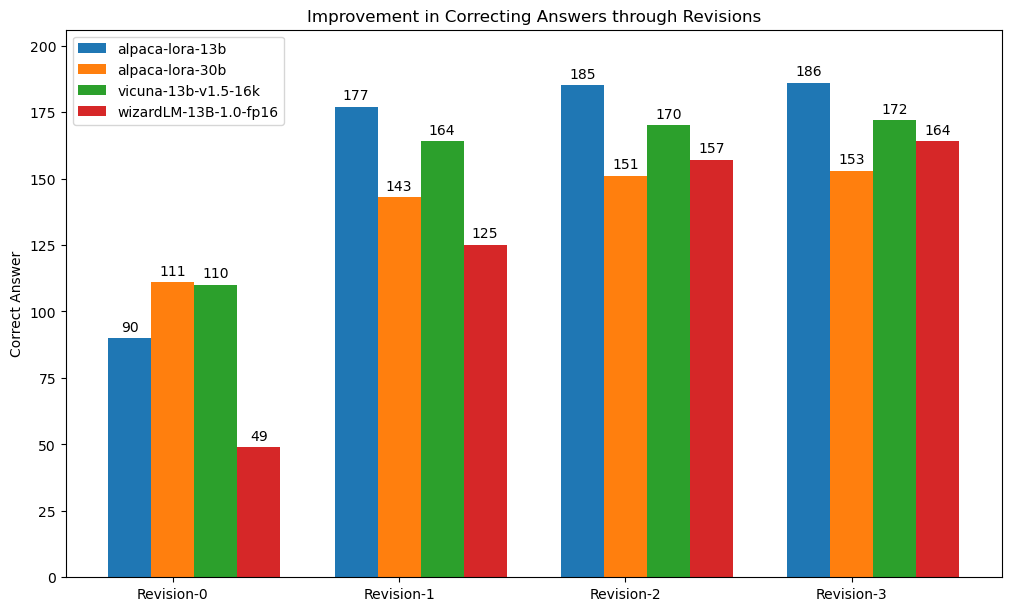

In [6]:
import matplotlib.pyplot as plt

iters = range(int(df_iter_cot_bootstrapping_performance["num-iteration-to-correct"].max()) + 1)
iterations = [f"Revision-{i}" for i in iters]

token_length_stats = {
    'alpaca-lora-13b': [df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["model-name"] == "alpaca-lora-13b") & (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == num_iteration)]["correct-answer"].values[0] for num_iteration in iters],
    'alpaca-lora-30b': [df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["model-name"] == "alpaca-lora-30b") & (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == num_iteration)]["correct-answer"].values[0] for num_iteration in iters],
    'vicuna-13b-v1.5-16k': [df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["model-name"] == "vicuna-13b-v1.5-16k") & (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == num_iteration)]["correct-answer"].values[0] for num_iteration in iters],
    'wizardLM-13B-1.0-fp16': [df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["model-name"] == "wizardLM-13B-1.0-fp16") & (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == num_iteration)]["correct-answer"].values[0] for num_iteration in iters]
}

x = np.arange(len(iterations))  # the label locations
width = 0.19  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10,6))

for attribute, measurement in token_length_stats.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correct Answer')
ax.set_title('Improvement in Correcting Answers through Revisions')
ax.set_xticks(x + width, iterations)
#ax.legend(loc='upper left', ncols=3)
ax.legend()
ax.set_ylim(0, int(df_iter_cot_bootstrapping_performance["correct-answer"].max()) + 20)

plt.show()

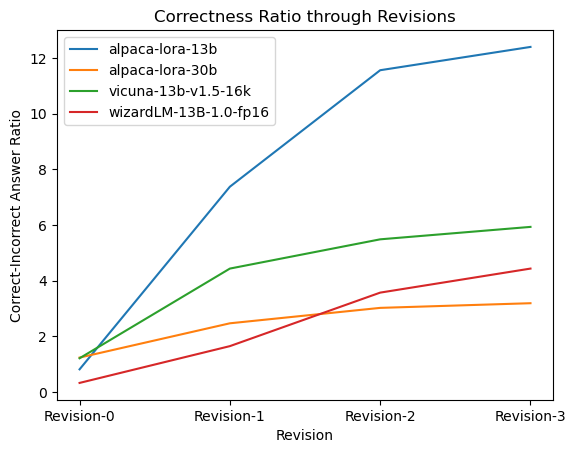

In [7]:
import matplotlib.pyplot as plt

iters = range(int(df_iter_cot_bootstrapping_performance["num-iteration-to-correct"].max()) + 1)
iterations = [f"Revision-{i}" for i in iters]

token_length_stats = {
    'alpaca-lora-13b': [df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["model-name"] == "alpaca-lora-13b") & (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == num_iteration)]["ratio-correct-incorrect"].values[0] for num_iteration in iters],
    'alpaca-lora-30b': [df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["model-name"] == "alpaca-lora-30b") & (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == num_iteration)]["ratio-correct-incorrect"].values[0] for num_iteration in iters],
    'vicuna-13b-v1.5-16k': [df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["model-name"] == "vicuna-13b-v1.5-16k") & (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == num_iteration)]["ratio-correct-incorrect"].values[0] for num_iteration in iters],
    'wizardLM-13B-1.0-fp16': [df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["model-name"] == "wizardLM-13B-1.0-fp16") & (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == num_iteration)]["ratio-correct-incorrect"].values[0] for num_iteration in iters]
}

plt.plot(iterations, token_length_stats['alpaca-lora-13b'], label='alpaca-lora-13b')  # Plot some data on the (implicit) axes.
plt.plot(iterations, token_length_stats['alpaca-lora-30b'], label='alpaca-lora-30b')  # etc.
plt.plot(iterations, token_length_stats['vicuna-13b-v1.5-16k'], label='vicuna-13b-v1.5-16k')
plt.plot(iterations, token_length_stats['wizardLM-13B-1.0-fp16'], label='wizardLM-13B-1.0-fp16')
plt.xlabel('Revision')
plt.ylabel('Correct-Incorrect Answer Ratio')
plt.title("Correctness Ratio through Revisions")
plt.legend()

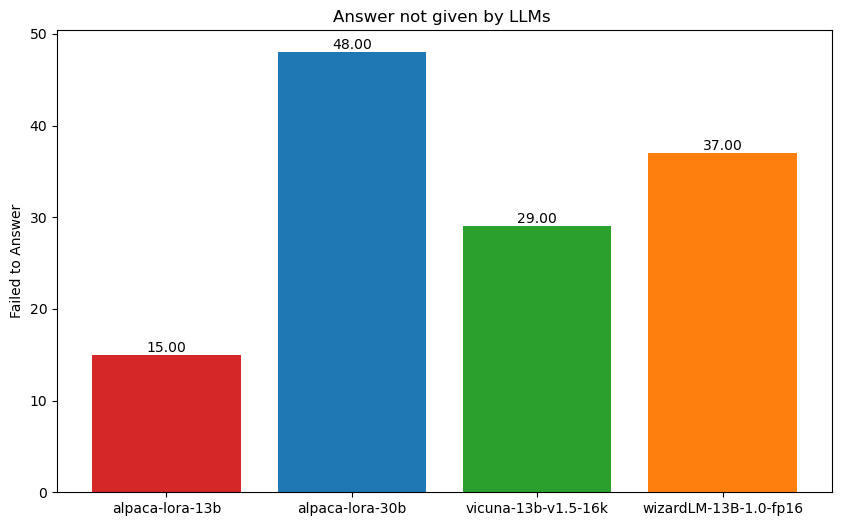

In [6]:
import matplotlib.pyplot as plt

df_can_not_answer = df_iter_cot_bootstrapping_performance[df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == -1][["model-name", "final-answer"]]

fig, ax = plt.subplots(figsize=(10,6))

llms = df_can_not_answer["model-name"].values
fail_to_answer = df_can_not_answer["final-answer"].values
bar_labels = llms
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']

bar_container = ax.bar(llms, fail_to_answer, label=bar_labels, color=bar_colors)

ax.set_ylabel('Failed to Answer')
ax.set_title('Answer not given by LLMs ')
#ax.legend(title='LLMs')
ax.bar_label(bar_container, fmt='%.2f')

plt.show()

In [7]:
#filedir = "/kaggle/working"
filedir = "/kaggle/input/strategyqa-train-dataset-with-llms"

In [8]:
# temporary because of batches and code completion
#index_file_name = "strategyqa-train-with-alpaca-13B-last-idx.csv"
#index_file_name = "strategyqa-train-with-alpaca-30B-last-idx.csv"
#index_file_name = "strategyqa-train-with-vicuna-13b-v1.5-16k-last-idx.csv"
index_file_name = "strategyqa-train-with-wizardLM-13B-last-idx.csv"

In [9]:
indexfilepath = f"{filedir}/{index_file_name}"

In [12]:
# temprary because of batches and code completion
# todo: it will be total record size which is shape[0]
#last_idx = get_last_index(f"/kaggle/working/{index_file_name}")
last_idx = get_last_index(indexfilepath)
#num_record = df_strategyqa_train.shape[0]
num_record = last_idx
print(last_idx)

201


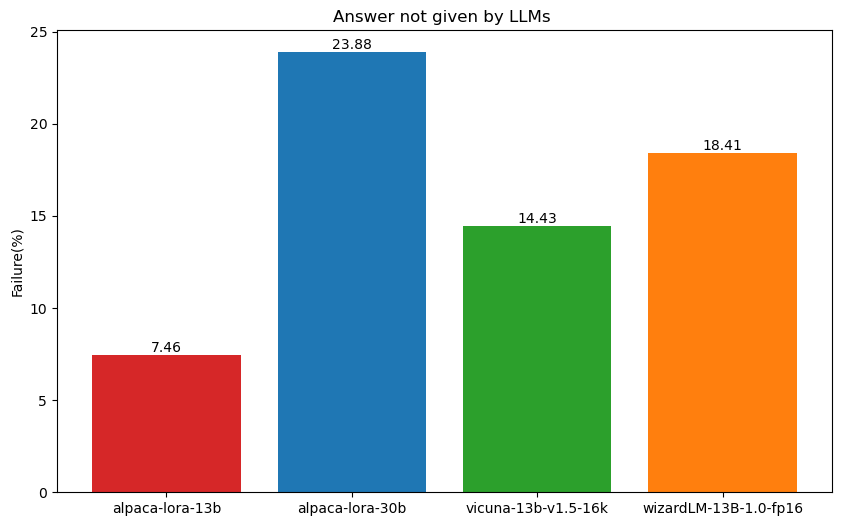

In [13]:
import matplotlib.pyplot as plt

df_can_not_answer = df_iter_cot_bootstrapping_performance[df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == -1][["model-name", "final-answer"]]

fig, ax = plt.subplots(figsize=(10,6))

llms = df_can_not_answer["model-name"].values
fail_to_answer = [((val / num_record) * 100.00) for val in df_can_not_answer["final-answer"].values]
bar_labels = llms
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']

bar_container = ax.bar(llms, fail_to_answer, label=bar_labels, color=bar_colors)

ax.set_ylabel('Failure(%)')
ax.set_title('Answer not given by LLMs ')
#ax.legend(title='LLMs')
ax.bar_label(bar_container, fmt='%.2f')

plt.show()

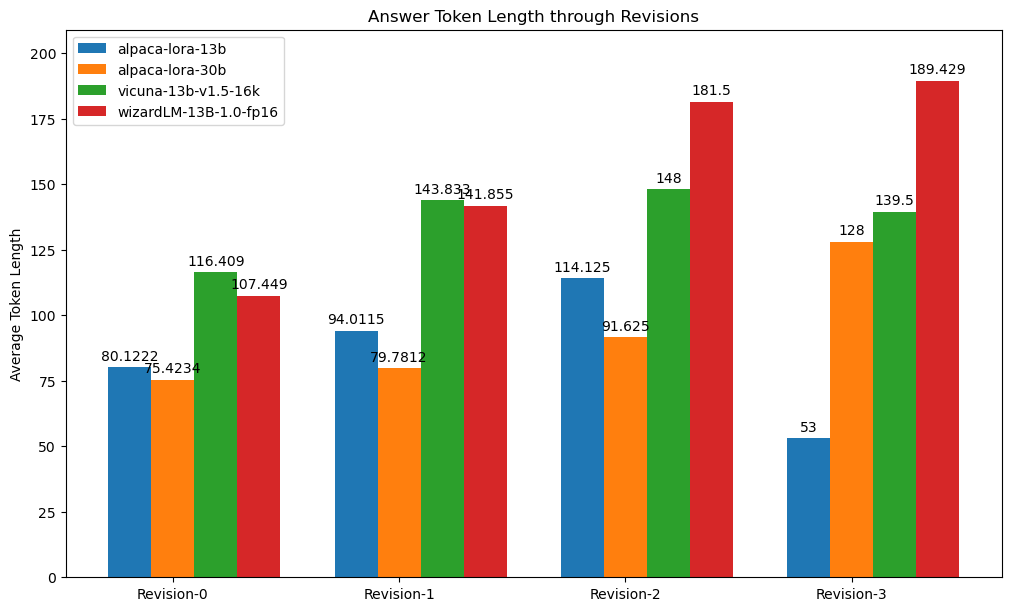

In [8]:
import matplotlib.pyplot as plt

iters = range(int(df_iter_cot_bootstrapping_performance["num-iteration-to-correct"].max()) + 1)
iterations = [f"Revision-{i}" for i in iters]

token_length_stats = {
    'alpaca-lora-13b': [df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["model-name"] == "alpaca-lora-13b") & (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == num_iteration)]["answer-tokens-average-length"].values[0] for num_iteration in iters],
    'alpaca-lora-30b': [df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["model-name"] == "alpaca-lora-30b") & (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == num_iteration)]["answer-tokens-average-length"].values[0] for num_iteration in iters],
    'vicuna-13b-v1.5-16k': [df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["model-name"] == "vicuna-13b-v1.5-16k") & (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == num_iteration)]["answer-tokens-average-length"].values[0] for num_iteration in iters],
    'wizardLM-13B-1.0-fp16': [df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["model-name"] == "wizardLM-13B-1.0-fp16") & (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == num_iteration)]["answer-tokens-average-length"].values[0] for num_iteration in iters]
}

x = np.arange(len(iterations))  # the label locations
width = 0.19  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10,6))

for attribute, measurement in token_length_stats.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Token Length')
ax.set_title('Answer Token Length through Revisions')
ax.set_xticks(x + width, iterations)
#ax.legend(loc='upper left', ncols=3)
ax.legend()
ax.set_ylim(0, int(df_iter_cot_bootstrapping_performance["answer-tokens-average-length"].max()) + 20)

plt.show()

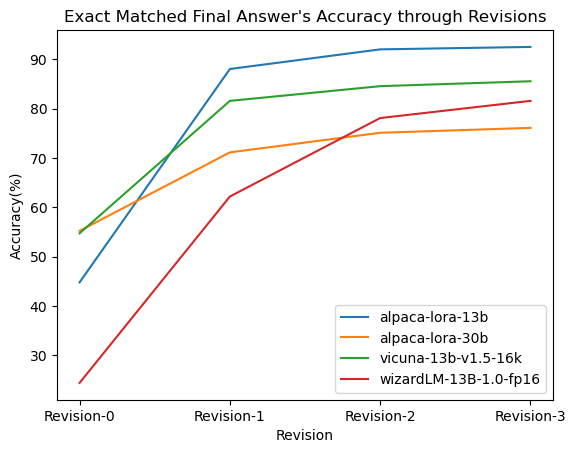

In [14]:
import matplotlib.pyplot as plt

iters = range(int(df_iter_cot_bootstrapping_performance["num-iteration-to-correct"].max()) + 1)
iterations = [f"Revision-{i}" for i in iters]

token_length_stats = {
    'alpaca-lora-13b': [df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["model-name"] == "alpaca-lora-13b") & (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == num_iteration)]["accuracy"].values[0] for num_iteration in iters],
    'alpaca-lora-30b': [df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["model-name"] == "alpaca-lora-30b") & (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == num_iteration)]["accuracy"].values[0] for num_iteration in iters],
    'vicuna-13b-v1.5-16k': [df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["model-name"] == "vicuna-13b-v1.5-16k") & (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == num_iteration)]["accuracy"].values[0] for num_iteration in iters],
    'wizardLM-13B-1.0-fp16': [df_iter_cot_bootstrapping_performance[(df_iter_cot_bootstrapping_performance["model-name"] == "wizardLM-13B-1.0-fp16") & (df_iter_cot_bootstrapping_performance["num-iteration-to-correct"] == num_iteration)]["accuracy"].values[0] for num_iteration in iters]
}

plt.plot(iterations, token_length_stats['alpaca-lora-13b'], label='alpaca-lora-13b')  # Plot some data on the (implicit) axes.
plt.plot(iterations, token_length_stats['alpaca-lora-30b'], label='alpaca-lora-30b')  # etc.
plt.plot(iterations, token_length_stats['vicuna-13b-v1.5-16k'], label='vicuna-13b-v1.5-16k')
plt.plot(iterations, token_length_stats['wizardLM-13B-1.0-fp16'], label='wizardLM-13B-1.0-fp16')
plt.xlabel('Revision')
plt.ylabel('Accuracy(%)')
plt.title("Exact Matched Final Answer's Accuracy through Revisions")
plt.legend()

The observed phenomenon can be attributed to the increasing difficulty level of corrected exemplars as the iteration progresses. Specifically, questions requiring multiple corrections exhibit a higher difficulty level than those resolvable in the initial iteration. (*Jiashuo Sun, Yi Luo, Yeyun Gong, Chen Lin, Yelong Shen, Jian Guo and Nan Duan. 2023. Enhancing Chain-of-Thoughts Prompting with Iterative Bootstrapping in Large Language Models. ArXiv, abs/2304.11657*)

In [ ]:
# Trials for a specific dataset and model 
# trial 1 = 8 samples = sampling from iteration 0 = easy exemplars = sampling-iteration-0
# trial 2 = 8 samples = sampling from iteration 1 = little hard exemplars = sampling-iteration-1
# trial 3 = 8 samples = sampling from iteration 2 = hard exemplars = sampling-iteration-2
# trial 4 = 8 samples = sampling from iteration 3 = harder exemplars = sampling-iteration-3
# trial 5 = 8 samples = sampling from iteration 4 = hardest exemplars = sampling-iteration-4
# trial 6 = 8 samples = sampling from iteration 0 to 4 = minimum 1 random sample from each iteration

# overall accuracy is the average accuracy of all trials

In [152]:
#file_name = "strategyqa-train-with-alpaca-13B-ans.csv"
#file_name = "strategyqa-train-with-alpaca-30B-ans.csv"
#file_name = "strategyqa-train-with-vicuna-13b-v1.5-16k-ans.csv"
file_name = "strategyqa-train-with-wizardLM-13B-ans.csv"

In [153]:
# temporary because of batches and code completion
#index_file_name = "strategyqa-train-with-alpaca-13B-last-idx.csv"
#index_file_name = "strategyqa-train-with-alpaca-30B-last-idx.csv"
#index_file_name = "strategyqa-train-with-vicuna-13b-v1.5-16k-last-idx.csv"
index_file_name = "strategyqa-train-with-wizardLM-13B-last-idx.csv"

In [154]:
#filedir = "/kaggle/working"
filedir = "/kaggle/input/strategyqa-train-dataset-with-llms"

In [155]:
filepath = f"{filedir}/{file_name}"
indexfilepath = f"{filedir}/{index_file_name}"

In [156]:
df_strategyqa_train = pd.read_csv(filepath)

In [157]:
# temprary because of batches and code completion
last_idx = get_last_index(indexfilepath)
print(last_idx)

df_strategyqa_train_1 = df_strategyqa_train[:last_idx]
df_strategyqa_train_iter_0 = df_strategyqa_train_1[df_strategyqa_train_1["num-iteration-to-correct"] == 0]
df_strategyqa_train_iter_1 = df_strategyqa_train_1[df_strategyqa_train_1["num-iteration-to-correct"] == 1]
df_strategyqa_train_iter_2 = df_strategyqa_train_1[df_strategyqa_train_1["num-iteration-to-correct"] == 2]
df_strategyqa_train_iter_3 = df_strategyqa_train_1[df_strategyqa_train_1["num-iteration-to-correct"] == 3]
df_strategyqa_train_iter_4 = df_strategyqa_train_1[df_strategyqa_train_1["num-iteration-to-correct"] == 4]
df_strategyqa_train_iter_5 = df_strategyqa_train_1[df_strategyqa_train_1["num-iteration-to-correct"] == 5]
df_strategyqa_train_iter_6 = df_strategyqa_train_1[df_strategyqa_train_1["num-iteration-to-correct"] == 6]

201


In [136]:
df_strategyqa_train_iter_2.shape

(6, 12)

In [162]:
num_samples = 8
trial_no = 0
strategyqa_demonstration_trials = []

In [163]:
if df_strategyqa_train_iter_0.shape[0] >= num_samples:
    trial_no = trial_no + 1
    strategyqa_demonstration_trials.append({
        "trial-no": trial_no,
        "demonstration-pool": "sampling-iteration-0",
        "samples": df_strategyqa_train_iter_0.sample(n=8, random_state=1, axis=0)
    })

In [164]:
if df_strategyqa_train_iter_1.shape[0] >= num_samples:
    trial_no = trial_no + 1
    strategyqa_demonstration_trials.append({
        "trial-no": trial_no,
        "demonstration-pool": "sampling-iteration-1",
        "samples": df_strategyqa_train_iter_1.sample(n=8, random_state=1, axis=0)
    })

In [165]:
if df_strategyqa_train_iter_2.shape[0] >= num_samples:
    trial_no = trial_no + 1
    strategyqa_demonstration_trials.append({
        "trial-no": trial_no,
        "demonstration-pool": "sampling-iteration-2",
        "samples": df_strategyqa_train_iter_2.sample(n=8, random_state=1, axis=0)
    })

In [166]:
if df_strategyqa_train_iter_3.shape[0] >= num_samples:
    trial_no = trial_no + 1
    strategyqa_demonstration_trials.append({
        "trial-no": trial_no,
        "demonstration-pool": "sampling-iteration-3",
        "samples": df_strategyqa_train_iter_3.sample(n=8, random_state=1, axis=0)
    })

In [167]:
if df_strategyqa_train_iter_4.shape[0] >= num_samples:
    trial_no = trial_no + 1
    strategyqa_demonstration_trials.append({
        "trial-no": trial_no,
        "demonstration-pool": "sampling-iteration-4",
        "samples": df_strategyqa_train_iter_4.sample(n=8, random_state=1, axis=0)
    })

In [130]:
if df_strategyqa_train_iter_5.shape[0] >= num_samples:
    trial_no = trial_no + 1
    strategyqa_demonstration_trials.append({
        "trial-no": trial_no,
        "demonstration-pool": "sampling-iteration-5",
        "samples": df_strategyqa_train_iter_5.sample(n=8, random_state=1, axis=0)
    })

In [168]:
if df_strategyqa_train_iter_6.shape[0] >= num_samples:
    trial_no = trial_no + 1
    strategyqa_demonstration_trials.append({
        "trial-no": trial_no,
        "demonstration-pool": "sampling-iteration-6",
        "samples": df_strategyqa_train_iter_6.sample(n=8, random_state=1, axis=0)
    })

In [169]:
trial_no = trial_no + 1
samples_for_trial = pd.DataFrame(data=[], columns=df_strategyqa_train.columns.values)
sample_count = 0
while sample_count != num_samples:
    if df_strategyqa_train_iter_0.shape[0] >= 1:
        samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_0.sample(n=1, random_state=1, axis=0)])
        sample_count = sample_count + 1
    if sample_count == num_samples:
        break
    if df_strategyqa_train_iter_1.shape[0] >= 1:
        samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_1.sample(n=1, random_state=1, axis=0)])
        sample_count = sample_count + 1
    if sample_count == num_samples:
        break
    if df_strategyqa_train_iter_2.shape[0] >= 1:
        samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_2.sample(n=1, random_state=1, axis=0)])
        sample_count = sample_count + 1
    if sample_count == num_samples:
        break
    if df_strategyqa_train_iter_3.shape[0] >= 1:
        samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_3.sample(n=1, random_state=1, axis=0)])
        sample_count = sample_count + 1
    if sample_count == num_samples:
        break
    if df_strategyqa_train_iter_4.shape[0] >= 1:
        samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_4.sample(n=1, random_state=1, axis=0)])
        sample_count = sample_count + 1
    if sample_count == num_samples:
        break
    if df_strategyqa_train_iter_5.shape[0] >= 1:
        samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_5.sample(n=1, random_state=1, axis=0)])
        sample_count = sample_count + 1
    if sample_count == num_samples:
        break
    if df_strategyqa_train_iter_6.shape[0] >= 1:
        samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_6.sample(n=1, random_state=1, axis=0)])
        sample_count = sample_count + 1
    if sample_count == num_samples:
        break
strategyqa_demonstration_trials.append({
    "trial-no": trial_no,
    "demonstration-pool": "sampling-iteration-mixed",
    "samples": samples_for_trial
})

/tmp/ipykernel_28/326827102.py:11: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_1.sample(n=1, random_state=1, axis=0)])
/tmp/ipykernel_28/326827102.py:16: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_2.sample(n=1, random_state=1, axis=0)])
/tmp/ipykernel_28/326827102.py:21: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  samples_for_trial = pd.concat([samples_for_trial, df_strategyqa_train_iter_3.sample(n=1, random_state=1, axis=0)])
/tmp/ipykernel_28/3268271

In [170]:
strategyqa_demonstration_trials

[{'trial-no': 1,
  'demonstration-pool': 'sampling-iteration-0',
  'samples':                       qid             term  \
  120  f233f8748574df6f4727          Disgust   
  137  d00ae50a07a5dd8b726c       Rede Globo   
  168  347eff30928ba07fa567      Charlemagne   
  200  0b201a9520a4745fcd59    Martin Luther   
  7    29bf9aa61ed4124cd84c  Albany, Georgia   
  26   a96d28e1221bfbcf50a9          CT scan   
  177  e7730031d304759520ba          Prussia   
  123  4c088a5366459f2256c6  Mental disorder   
  
                                             description  \
  120                                      Basic emotion   
  137            Brazilian commercial television network   
  168  King of the Franks, King of Italy, and Holy Ro...   
  200  Saxon priest, monk and theologian, seminal fig...   
  7                       City in Georgia, United States   
  26   medical imaging procedure which uses X-rays to...   
  177          state in Central Europe between 1525–1947   
  123    

In [ ]:
# below code for evaluation

In [30]:
df_strategyqa_eval = pd.read_json("/kaggle/input/strategyqa-dataset-for-thesis/strategyqa_train_filtered.json")
df_strategyqa_eval

,qid,term,description,question,answer
0,872,Swastika,a geometrical figure and an ancient religious ...,Did the Hopi Indians use a symbol that was sim...,True
1,874,Year,Orbital period of the Earth around the Sun,is there a david bowie song with the word year...,True
2,875,Shropshire,County of England,Were Charles Darwin and A.E. Housman born in S...,True
3,876,Shropshire,County of England,Are there several towns located in Shropshire?,True
4,877,Shropshire,County of England,Is Lord Hill's column in Shropshire the talles...,True
...,...,...,...,...,...
2816,9173,Cactus,"Family of mostly succulent plants, adapted to ...",Would an aerodynamic cactus dessicate more qui...,True
2817,9180,Persian Gulf,An arm of the Indian Ocean in western Asia,Would an oil miner be interested in the Persia...,True
2818,9182,Drain fly,family of insects,Are drain flies able to survive bleach?,True
2819,9183,Lentil,Species of plant,Are Lentil able to withstand frost?,True


In [75]:
from ydata_profiling import ProfileReport

data_profile_config_path = "/kaggle/input/data-profile/bht_thesis_config_1.yaml"
strategyqa_data_profile_path = "/kaggle/working/df_strategyqa_train_filtered_report_v1.html"
profile = ProfileReport(df_strategyqa_eval, title="StrategyQA Evaluation Data Profiling Report v1", config_file=data_profile_config_path)
profile.to_file(strategyqa_data_profile_path)

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#file_name = "strategyqa-train-filtered-with-alpaca-13B-ans.csv"
#file_name = "strategyqa-train-filtered-with-alpaca-30B-ans.csv"
#file_name = "strategyqa-train-filtered-with-vicuna-13b-v1.5-16k-ans.csv"
#file_name = "strategyqa-train-filtered-with-wizardLM-13B-ans.csv"

In [31]:
#file_name = "strategyqa-test-with-alpaca-13B-ans.csv"
#file_name = "strategyqa-test-with-alpaca-30B-ans.csv"
#file_name = "strategyqa-test-with-vicuna-13b-v1.5-16k-ans.csv"
file_name = "strategyqa-test-with-wizardLM-13B-ans.csv"

In [32]:
#filedir = "/kaggle/working"
filedir = "/kaggle/input/strategyqa-test-dataset-with-llms"

In [33]:
filepath = f"{filedir}/{file_name}"

In [34]:
file_exist = is_file_exist(filedir, file_name)
file_exist

True

In [35]:
if file_exist == True:
    df_strategyqa_eval = pd.read_csv(filepath)
else:
    default_ans = (['na' for i in range(df_strategyqa_eval.shape[0])], [False for i in range(df_strategyqa_eval.shape[0])])
    for strategyqa_demonstration_trial in strategyqa_demonstration_trials:
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-8", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-8-correct", default_ans[1])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-7", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-7-correct", default_ans[1])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-6", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-6-correct", default_ans[1])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-5", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-5-correct", default_ans[1])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-4", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-4-correct", default_ans[1])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-3", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-3-correct", default_ans[1])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-2", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-2-correct", default_ans[1])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-1", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-1-correct", default_ans[1])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-0", default_ans[0])
        df_strategyqa_eval.insert(df_strategyqa_eval.shape[1], f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-0-correct", default_ans[1])
df_strategyqa_eval

,qid,term,description,question,answer,trial-1-iter-cot-answer-8,trial-1-iter-cot-answer-8-correct,trial-1-iter-cot-answer-7,trial-1-iter-cot-answer-7-correct,trial-1-iter-cot-answer-6,...,trial-4-iter-cot-answer-4,trial-4-iter-cot-answer-4-correct,trial-4-iter-cot-answer-3,trial-4-iter-cot-answer-3-correct,trial-4-iter-cot-answer-2,trial-4-iter-cot-answer-2-correct,trial-4-iter-cot-answer-1,trial-4-iter-cot-answer-1-correct,trial-4-iter-cot-answer-0,trial-4-iter-cot-answer-0-correct
0,872,Swastika,a geometrical figure and an ancient religious ...,Did the Hopi Indians use a symbol that was sim...,True,A: Reasoning: The Hopi tribe is a Native Ameri...,False,A: Reasoning: The Hopi tribe is Native America...,False,A: Reasoning: The Hopi tribe is Native America...,...,A: Reasoning: \n1. The swastika is a well-know...,False,A: Reasoning: \nThe Hopi people are Native Ame...,False,A: Reasoning: While it is true that the Hopi p...,True,A: Reasoning: The Hopi people did not use a sy...,False,A: Reasoning: The Hopi people were known to us...,False
1,874,Year,Orbital period of the Earth around the Sun,is there a david bowie song with the word year...,True,A: Reasoning: David Bowie was a British musici...,True,A: Reasoning: David Bowie had a long career as...,True,A: Reasoning: David Bowie was a famous musicia...,...,A: Reasoning: David Bowie had a prolific caree...,True,A: Reasoning: David Bowie was a prolific music...,False,A: Reasoning: David Bowie had a prolific caree...,True,A: Reasoning: David Bowie had many songs with ...,True,A: Reasoning: David Bowie was known for his cr...,False
2,875,Shropshire,County of England,Were Charles Darwin and A.E. Housman born in S...,True,A: Reasoning: Charles Darwin was born in Shrew...,True,A: Reasoning: Charles Darwin was born in Shrew...,True,A: Reasoning: Charles Darwin was born in Shrew...,...,A: Reasoning: \nCharles Darwin was born in Shr...,True,A: Reasoning: Charles Darwin was born in Shrew...,False,A: Reasoning: Charles Darwin was actually born...,False,"A: Reasoning: George Orwell wrote ""1984"". He w...",False,A: Reasoning: \nShropshire is a county located...,False
3,876,Shropshire,County of England,Are there several towns located in Shropshire?,True,A: Reasoning: Shropshire is a county located i...,True,A: Reasoning: Shropshire is a county located i...,False,A: Reasoning: Shropshire is a county located i...,...,A: Reasoning: \nShropshire is a county located...,True,A: Reasoning: \nShropshire is a county located...,True,A: Reasoning: Shropshire is a large county in ...,True,A: Reasoning: There are many small villages an...,True,"A: Reasoning: Yes, there are many towns locate...",False
4,877,Shropshire,County of England,Is Lord Hill's column in Shropshire the talles...,True,A: Reasoning: Lord Hill's Column is a monument...,False,A: Reasoning: Lord Hill's Column is a monument...,False,A: Reasoning: Lord Hill's Column is a monument...,...,A: Reasoning: \nLord Hill's Column is a monume...,False,A: Reasoning: Lord Hill's Column is a monument...,False,A: Reasoning: Lord Hill's Column is indeed con...,False,A: Reasoning: Cakes are typically sweeter and ...,False,A: Reasoning: \nLord Hill's Column is located ...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2816,9173,Cactus,"Family of mostly succulent plants, adapted to ...",Would an aerodynamic cactus dessicate more qui...,True,na,False,na,False,na,...,na,False,na,False,na,False,na,False,na,False
2817,9180,Persian Gulf,An arm of the Indian Ocean in western Asia,Would an oil miner be interested in the Persia...,True,na,False,na,False,na,...,na,False,na,False,na,False,na,False,na,False
2818,9182,Drain fly,family of insects,Are drain flies able to survive bleach?,True,na,False,na,False,na,...,na,False,na,False,na,False,na,False,na,False
2819,9183,Lentil,Species of plant,Are Lentil able to withstand frost?,True,na,False,na,False,na,...,na,False,na,False,na,False,na,False,na,False


In [ ]:
#index_file_name = "strategyqa-train-filtered-with-alpaca-13B-last-idx.csv"
#index_file_name = "strategyqa-train-filtered-with-alpaca-30B-last-idx.csv"
#index_file_name = "strategyqa-train-filtered-with-vicuna-13b-v1.5-16k-last-idx.csv"
#index_file_name = "strategyqa-train-filtered-with-wizardLM-13B-last-idx.csv"

In [51]:
#index_file_name = "strategyqa-test-with-alpaca-13B-last-idx.csv"
#index_file_name = "strategyqa-test-with-alpaca-30B-last-idx.csv"
#index_file_name = "strategyqa-test-with-vicuna-13b-v1.5-16k-last-idx.csv"
index_file_name = "strategyqa-test-with-wizardLM-13B-last-idx.csv"

In [52]:
#filedir = "/kaggle/working"
filedir = "/kaggle/input/strategyqa-test-dataset-with-llms"

In [53]:
filepath = f"{filedir}/{index_file_name}"

In [55]:
last_idx = get_last_index(filepath)
last_idx

51

In [40]:
batch_size = 50
df_strategyqa_eval_batches = make_batches_from_dataset(df_strategyqa_eval[last_idx:], batch_size)

In [41]:
iter_cot_few_shots_prompt = f"""Act as a Strategic Reasoning Expert. You have knowledge to answer questions using the reasoning steps which should be inferred using strategy.
Your task is to think deeply, step by step and answer the given question using step by step reasoning approach. Your final answer always derives from your reasoning paragraph.

I am going to provide a template for your output. <placeholder> are my placeholders for content. Try to fit the output into one or more of the placeholders that I list. \
Please preserve the formatting and overall template that I provide.

This is the template:
A: Reasoning: <small reasoning paragraph> Final Answer: <final answer as yes or no>"""

In [42]:
few_shots_exemplars = [
    f"""Q: {sfd[1]["term"]}, {sfd[1]["description"]}, {sfd[1]["question"]}
{sfd[1]["iter-cot-answer"]}""" for sfd in strategyqa_demonstration_trials[0]["samples"].iterrows()
]

In [106]:
few_shots_exemplars

["Q: Doctor Strange, Superhero appearing in Marvel Comics publications and related media, Did Doctor Strange creators also make Batman?\nA: Reasoning: No, Doctor Strange was created by Steve Ditko while Batman was created by Bob Kane and Bill Finger. Both characters were introduced in the 1960s but they belong to different comic book companies. Doctor Strange's first appearance was in Strange Tales #110 (cover-dated July 1963) whereas Batman's first appearance was in Detective Comics #27 (May 1939). Therefore, it can be concluded that Doctor Strange's creators did not create Batman. Final Answer: No",
 "Q: Pear, genus of plants, Would a pear sink in water?\nA: Reasoning: A pear is an aquatic plant, it would not float but also wouldn't sink. It would remain at the surface because its density is similar to that of water. Therefore, we can say that a pear would not sink in water. Final Answer: No",
 'Q: Stoning, execution method, Would George Fox support stoning?\nA: Reasoning: George Fox

In [45]:
few_shots_exemplars[0]

'Q: Doctor Strange, Superhero appearing in Marvel Comics publications and related media, Did Doctor Strange creators also make Batman?\nA: Reasoning: \nDoctor Strange was created by Stan Lee and Steve Ditko in 1963. They were both comics writers who worked on many different characters over their careers. However, they did not create Batman. Batman was created by Bob Kane and Bill Finger in 1939. Therefore, the answer to this question is No. Final Answer: no'

In [46]:
print(iter_cot_few_shots_prompt + "\n\n" + "\n\n".join(few_shots_exemplars[:6]))

Act as a Strategic Reasoning Expert. You have knowledge to answer questions using the reasoning steps which should be inferred using strategy.
Your task is to think deeply, step by step and answer the given question using step by step reasoning approach. Your final answer always derives from your reasoning paragraph.

I am going to provide a template for your output. <placeholder> are my placeholders for content. Try to fit the output into one or more of the placeholders that I list. Please preserve the formatting and overall template that I provide.

This is the template:
A: Reasoning: <small reasoning paragraph> Final Answer: <final answer as yes or no>

Q: Doctor Strange, Superhero appearing in Marvel Comics publications and related media, Did Doctor Strange creators also make Batman?
A: Reasoning: 
Doctor Strange was created by Stan Lee and Steve Ditko in 1963. They were both comics writers who worked on many different characters over their careers. However, they did not create Bat

In [ ]:
#file_name = "strategyqa-train-filtered-with-alpaca-13B-ans.csv"
#index_file_name = "strategyqa-train-filtered-with-alpaca-13B-last-idx.csv"

#file_name = "strategyqa-train-filtered-with-alpaca-30B-ans.csv"
#index_file_name = "strategyqa-train-filtered-with-alpaca-30B-last-idx.csv"

#file_name = "strategyqa-train-filtered-with-vicuna-13b-v1.5-16k-ans.csv"
#index_file_name = "strategyqa-train-filtered-with-vicuna-13b-v1.5-16k-last-idx.csv"

#file_name = "strategyqa-train-filtered-with-wizardLM-13B-ans.csv"
#index_file_name = "strategyqa-train-filtered-with-wizardLM-13B-last-idx.csv"

In [43]:
#file_name = "strategyqa-test-with-alpaca-13B-ans.csv"
#index_file_name = "strategyqa-test-with-alpaca-13B-last-idx.csv"

#file_name = "strategyqa-test-with-alpaca-30B-ans.csv"
#index_file_name = "strategyqa-test-with-alpaca-30B-last-idx.csv"

#file_name = "strategyqa-test-with-vicuna-13b-v1.5-16k-ans.csv"
#index_file_name = "strategyqa-test-with-vicuna-13b-v1.5-16k-last-idx.csv"

file_name = "strategyqa-test-with-wizardLM-13B-ans.csv"
index_file_name = "strategyqa-test-with-wizardLM-13B-last-idx.csv"

In [44]:
batch_count = 1
got_exception = False
for df_strategyqa_eval_batch in df_strategyqa_eval_batches:
    print(f"Batch: {batch_count}")
    print("-----------------------------")
    got_exception = False
    for strategyqa in df_strategyqa_eval_batch.iterrows():
        question = f"""{strategyqa[1]["term"]}, {strategyqa[1]["description"]}, {strategyqa[1]["question"]}"""
        got_exception = False
        for strategyqa_demonstration_trial in strategyqa_demonstration_trials:
            print(f"Trial: {strategyqa_demonstration_trial['trial-no']}")
            print("-----------------------------")
            few_shots_exemplars = [
                f"""Q: {sfd[1]["term"]}, {sfd[1]["description"]}, {sfd[1]["question"]}
{sfd[1]["iter-cot-answer"]}""" for sfd in strategyqa_demonstration_trial["samples"].iterrows()
            ]
            try:
                iter_cot_inference_module(strategyqa_demonstration_trial["trial-no"], batch_count, few_shots_exemplars, strategyqa[0], question, strategyqa[1]["answer"])
            except Exception as exp:
                # print message
                print(f"Batch: {batch_count}, Trial: {strategyqa_demonstration_trial['trial-no']}")
                print(exp)
                # save data till previous iteration df, file_name, idx_file_name
                if last_idx != 0:
                    save_data_till_last_iteration(df_strategyqa_eval, f"/kaggle/working/{file_name}", f"/kaggle/working/{index_file_name}")
                got_exception = True
                break
        if got_exception == True:
            break
        last_idx = last_idx + 1
        save_data_till_last_iteration(df_strategyqa_eval, f"/kaggle/working/{file_name}", f"/kaggle/working/{index_file_name}")
        time.sleep(60)
    if got_exception == True:
        break
    batch_count = batch_count + 1
    time.sleep(60)

Batch: 1
-----------------------------
Trial: 1
-----------------------------
Generating...


/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration

trail no : 1, batch number : 1, index : 36
------------------------------------------
<s> Act as a Strategic Reasoning Expert. You have knowledge to answer questions using the reasoning steps which should be inferred using strategy.
Your task is to think deeply, step by step and answer the given question using step by step reasoning approach. Your final answer always derives from your reasoning paragraph.

I am going to provide a template for your output. <placeholder> are my placeholders for content. Try to fit the output into one or more of the placeholders that I list. Please preserve the formatting and overall template that I provide.

This is the template:
A: Reasoning: <small reasoning paragraph> Final Answer: <final answer as yes or no>

Q: Prussia, state in Central Europe between 1525–1947, Could someone from Prussia communicate easily with Wilhelm Miklas?
A: Reasoning: Prussia was a historical region located in Central Europe, it existed between 1525-1947. It consisted of vari

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration

trail no : 1, batch number : 1, index : 36
------------------------------------------
<s> Act as a Strategic Reasoning Expert. You have knowledge to answer questions using the reasoning steps which should be inferred using strategy.
Your task is to think deeply, step by step and answer the given question using step by step reasoning approach. Your final answer always derives from your reasoning paragraph.

I am going to provide a template for your output. <placeholder> are my placeholders for content. Try to fit the output into one or more of the placeholders that I list. Please preserve the formatting and overall template that I provide.

This is the template:
A: Reasoning: <small reasoning paragraph> Final Answer: <final answer as yes or no>

Q: Disgust, Basic emotion, Do frogs feel disgust?
A: Reasoning: Frog's nervous system is different than human's nervous system, so it may not experience emotions in the same way humans do. However, some research suggests that certain species of 

Token indices sequence length is longer than the specified maximum sequence length for this model (2158 > 2048). Running this sequence through the model will result in indexing errors


trail no : 4, batch number : 1, index : 36
------------------------------------------
<s> Act as a Strategic Reasoning Expert. You have knowledge to answer questions using the reasoning steps which should be inferred using strategy.
Your task is to think deeply, step by step and answer the given question using step by step reasoning approach. Your final answer always derives from your reasoning paragraph.

I am going to provide a template for your output. <placeholder> are my placeholders for content. Try to fit the output into one or more of the placeholders that I list. Please preserve the formatting and overall template that I provide.

This is the template:
A: Reasoning: <small reasoning paragraph> Final Answer: <final answer as yes or no>

Q: Disgust, Basic emotion, Do frogs feel disgust?
A: Reasoning: Frog's nervous system is different than human's nervous system, so it may not experience emotions in the same way humans do. However, some research suggests that certain species of 

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


trail no : 4, batch number : 1, index : 36
------------------------------------------
<s> Act as a Strategic Reasoning Expert. You have knowledge to answer questions using the reasoning steps which should be inferred using strategy.
Your task is to think deeply, step by step and answer the given question using step by step reasoning approach. Your final answer always derives from your reasoning paragraph.

I am going to provide a template for your output. <placeholder> are my placeholders for content. Try to fit the output into one or more of the placeholders that I list. Please preserve the formatting and overall template that I provide.

This is the template:
A: Reasoning: <small reasoning paragraph> Final Answer: <final answer as yes or no>

Q: Disgust, Basic emotion, Do frogs feel disgust?
A: Reasoning: Frog's nervous system is different than human's nervous system, so it may not experience emotions in the same way humans do. However, some research suggests that certain species of 

KeyboardInterrupt: 

In [56]:
df_strategyqa_eval

,qid,term,description,question,answer,trial-1-iter-cot-answer-8,trial-1-iter-cot-answer-8-correct,trial-1-iter-cot-answer-7,trial-1-iter-cot-answer-7-correct,trial-1-iter-cot-answer-6,...,trial-3-iter-cot-answer-4,trial-3-iter-cot-answer-4-correct,trial-3-iter-cot-answer-3,trial-3-iter-cot-answer-3-correct,trial-3-iter-cot-answer-2,trial-3-iter-cot-answer-2-correct,trial-3-iter-cot-answer-1,trial-3-iter-cot-answer-1-correct,trial-3-iter-cot-answer-0,trial-3-iter-cot-answer-0-correct
0,872,Swastika,a geometrical figure and an ancient religious ...,Did the Hopi Indians use a symbol that was sim...,True,A: Reasoning: The Hopi Indians did not use a s...,False,"A: Reasoning: \nYes, the Hopis did use a symbo...",True,"A: Reasoning: \nYes, the Hopis did use a symbo...",...,"A: Reasoning: \nYes, the Hopi Indians did use ...",False,"A: Reasoning: \nYes, the Hopi Indians did use ...",True,"A: Reasoning: \nYes, the Hopi Indians used a s...",False,A: Reasoning: \nThe Hopi Indians did not use a...,False,A: Reasoning: The Hopi Indians were known to h...,False
1,874,Year,Orbital period of the Earth around the Sun,is there a david bowie song with the word year...,True,A: Reasoning: David Bowie had several songs wi...,False,A: Reasoning: David Bowie had several songs wi...,False,A: Reasoning: David Bowie released several son...,...,A: Reasoning: \nDavid Bowie has many songs wit...,True,"A: Reasoning: \nYes, David Bowie has several s...",True,"A: Reasoning: \nYes, David Bowie has a song ca...",True,A: Reasoning: \nDavid Bowie has many songs wit...,True,A: Reasoning: David Bowie has released many so...,False
2,875,Shropshire,County of England,Were Charles Darwin and A.E. Housman born in S...,True,A: Reasoning: Charles Darwin was born in Shrew...,False,A: Reasoning: Charles Darwin was born in Shrew...,True,A: Reasoning: Charles Darwin was born in Shrew...,...,A: Reasoning: \nCharles Darwin was born in Shr...,False,A: Reasoning: \nCharles Darwin was born in Shr...,True,A: Reasoning: Both were born in Shropshire. Fi...,True,A: Reasoning: \nCharles Darwin was born in Shr...,True,A: Reasoning: 1) Charles Darwin was born on Fe...,False
3,876,Shropshire,County of England,Are there several towns located in Shropshire?,True,A: Reasoning: There are multiple towns located...,True,A: Reasoning: There are numerous small village...,True,A: Reasoning: There are numerous small village...,...,A: Reasoning: There are many small villages an...,True,A: Reasoning: There are many small villages an...,False,A: Reasoning: There are many small villages an...,True,"A: Reasoning: \nYes, there are many towns loca...",True,"A: Reasoning: Yes, there are many towns locate...",True
4,877,Shropshire,County of England,Is Lord Hill's column in Shropshire the talles...,True,A: Reasoning: Lord Hill's Column stands at 30 ...,True,A: Reasoning: Lord Hill's Column stands at 30 ...,True,A: Reasoning: Lord Hill's Column stands at 30 ...,...,A: Reasoning: \nLord Hill’s Column is the tall...,False,A: Reasoning: \nLord Hill’s Column is the tall...,True,"A: Reasoning: Yes, it is the tallest Doric Col...",True,A: Reasoning: \nLord Hills Column is the talle...,True,A: Reasoning: \nLord Hill's Column was built i...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2816,9173,Cactus,"Family of mostly succulent plants, adapted to ...",Would an aerodynamic cactus dessicate more qui...,True,na,False,na,False,na,...,na,False,na,False,na,False,na,False,na,False
2817,9180,Persian Gulf,An arm of the Indian Ocean in western Asia,Would an oil miner be interested in the Persia...,True,na,False,na,False,na,...,na,False,na,False,na,False,na,False,na,False
2818,9182,Drain fly,family of insects,Are drain flies able to survive bleach?,True,na,False,na,False,na,...,na,False,na,False,na,False,na,False,na,False
2819,9183,Lentil,Species of plant,Are Lentil able to withstand frost?,True,na,False,na,False,na,...,na,False,na,False,na,False,na,False,na,False


In [49]:
last_idx

4

In [ ]:
#file_name = "strategyqa-train-filtered-with-alpaca-13B-ans.csv"
#index_file_name = "strategyqa-train-filtered-with-alpaca-13B-last-idx.csv"

#file_name = "strategyqa-train-filtered-with-alpaca-30B-ans.csv"
#index_file_name = "strategyqa-train-filtered-with-alpaca-30B-last-idx.csv"

#file_name = "strategyqa-train-filtered-with-vicuna-13b-v1.5-16k-ans.csv"
#index_file_name = "strategyqa-train-filtered-with-vicuna-13b-v1.5-16k-last-idx.csv"

#file_name = "strategyqa-train-filtered-with-wizardLM-13B-ans.csv"
#index_file_name = "strategyqa-train-filtered-with-wizardLM-13B-last-idx.csv"

In [45]:
#file_name = "strategyqa-test-with-alpaca-13B-ans.csv"
#index_file_name = "strategyqa-test-with-alpaca-13B-last-idx.csv"

#file_name = "strategyqa-test-with-alpaca-30B-ans.csv"
#index_file_name = "strategyqa-test-with-alpaca-30B-last-idx.csv"

#file_name = "strategyqa-test-with-vicuna-13b-v1.5-16k-ans.csv"
#index_file_name = "strategyqa-test-with-vicuna-13b-v1.5-16k-last-idx.csv"

file_name = "strategyqa-test-with-wizardLM-13B-ans.csv"
index_file_name = "strategyqa-test-with-wizardLM-13B-last-idx.csv"

In [46]:
save_data_till_last_iteration(df_strategyqa_eval, f"/kaggle/working/{file_name}", f"/kaggle/working/{index_file_name}")

In [137]:
strategyqa_demonstration_trials

[{'trial-no': 1,
  'demonstration-pool': 'sampling-iteration-0',
  'samples':                       qid                      term  \
  167  89a19bd8f2bea335bca1            Doctor Strange   
  78   e0a9f1ef5fae44427b26                      Pear   
  100  806a13f37055bd21fddc                   Stoning   
  152  74936a1e1f16a8e97d68            Kelly Clarkson   
  125  f815aaa22d608f1dcb84                    Eminem   
  187  721d168ff5cc0b18c31b               Tonsillitis   
  181  e44e24c2c3b8599b85ad  War in Vietnam (1945–46)   
  103  03c467f12c3fcc1d91fe           Clouded leopard   
  
                                             description  \
  167  Superhero appearing in Marvel Comics publicati...   
  78                                     genus of plants   
  100                                   execution method   
  152  American singer-songwriter, actress, and telev...   
  125                          American rapper and actor   
  187                        Inflammation of the

In [ ]:
#file_name = "strategyqa-train-filtered-with-alpaca-13B-ans.csv"
#index_file_name = "strategyqa-train-filtered-with-alpaca-13B-last-idx.csv"

#file_name = "strategyqa-train-filtered-with-alpaca-30B-ans.csv"
#index_file_name = "strategyqa-train-filtered-with-alpaca-30B-last-idx.csv"

#file_name = "strategyqa-train-filtered-with-vicuna-13b-v1.5-16k-ans.csv"
#index_file_name = "strategyqa-train-filtered-with-vicuna-13b-v1.5-16k-last-idx.csv"

#file_name = "strategyqa-train-filtered-with-wizardLM-13B-ans.csv"
#index_file_name = "strategyqa-train-filtered-with-wizardLM-13B-last-idx.csv"

In [171]:
#file_name = "strategyqa-test-with-alpaca-13B-ans.csv"
#index_file_name = "strategyqa-test-with-alpaca-13B-last-idx.csv"

#file_name = "strategyqa-test-with-alpaca-30B-ans.csv"
#index_file_name = "strategyqa-test-with-alpaca-30B-last-idx.csv"

#file_name = "strategyqa-test-with-vicuna-13b-v1.5-16k-ans.csv"
#index_file_name = "strategyqa-test-with-vicuna-13b-v1.5-16k-last-idx.csv"

file_name = "strategyqa-test-with-wizardLM-13B-ans.csv"
index_file_name = "strategyqa-test-with-wizardLM-13B-last-idx.csv"

In [172]:
#filedir = "/kaggle/working"
filedir = "/kaggle/input/strategyqa-test-dataset-with-llms"

In [173]:
filepath = f"{filedir}/{file_name}"
indexfilepath = f"{filedir}/{index_file_name}"

In [174]:
df_strategyqa_eval = pd.read_csv(filepath)

# temprary because of batches and code completion
# todo: it will be total record size which is shape[0]
last_idx = get_last_index(indexfilepath)
#num_record = df_strategyqa_eval.shape[0]
num_record = last_idx
print(num_record)

# temprary because of batches and code completion
# todo: it will be total record size which is shape[0]
df_strategyqa_eval = df_strategyqa_eval[:num_record]


dataset_name = []
model_name = []
trial_no = []
demonstration_pool = []
iter_cot_answer_8_accuracy = []
iter_cot_answer_7_accuracy = []
iter_cot_answer_6_accuracy = []
iter_cot_answer_5_accuracy = []
iter_cot_answer_4_accuracy = []
iter_cot_answer_3_accuracy = []
iter_cot_answer_2_accuracy = []
iter_cot_answer_1_accuracy = []
iter_cot_answer_0_accuracy = []
iter_cot_answer_avg_accuracy = []

for strategyqa_demonstration_trial in strategyqa_demonstration_trials:
    dataset_name.append("StrategyQA")
    model_name.append(llm_name)
    trial_no.append(strategyqa_demonstration_trial["trial-no"])
    demonstration_pool.append(strategyqa_demonstration_trial["demonstration-pool"])
    
    answer_8_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-8-correct"]].shape[0]) / float(num_record) * 100.00
    answer_7_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-7-correct"]].shape[0]) / float(num_record) * 100.00
    answer_6_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-6-correct"]].shape[0]) / float(num_record) * 100.00
    answer_5_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-5-correct"]].shape[0]) / float(num_record) * 100.00
    answer_4_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-4-correct"]].shape[0]) / float(num_record) * 100.00
    answer_3_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-3-correct"]].shape[0]) / float(num_record) * 100.00
    answer_2_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-2-correct"]].shape[0]) / float(num_record) * 100.00
    answer_1_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-1-correct"]].shape[0]) / float(num_record) * 100.00
    answer_0_accuracy = float(df_strategyqa_eval["qid"][df_strategyqa_eval[f"trial-{strategyqa_demonstration_trial['trial-no']}-iter-cot-answer-0-correct"]].shape[0]) / float(num_record) * 100.00
    answer_avg_accuracy = (answer_0_accuracy + answer_1_accuracy + answer_2_accuracy + answer_3_accuracy + answer_4_accuracy + answer_5_accuracy + answer_6_accuracy + answer_7_accuracy + answer_8_accuracy) / 9.00
    
    iter_cot_answer_8_accuracy.append(answer_8_accuracy)
    iter_cot_answer_7_accuracy.append(answer_7_accuracy)
    iter_cot_answer_6_accuracy.append(answer_6_accuracy)
    iter_cot_answer_5_accuracy.append(answer_5_accuracy)
    iter_cot_answer_4_accuracy.append(answer_4_accuracy)
    iter_cot_answer_3_accuracy.append(answer_3_accuracy)
    iter_cot_answer_2_accuracy.append(answer_2_accuracy)
    iter_cot_answer_1_accuracy.append(answer_1_accuracy)
    iter_cot_answer_0_accuracy.append(answer_0_accuracy)
    iter_cot_answer_avg_accuracy.append(answer_avg_accuracy)


dict_strategyqa_eval = {
    "dataset-name": dataset_name,
    "model-name": model_name,
    "trial-no": trial_no,
    "demonstration-pool": demonstration_pool,
    "iter-cot-answer-8-accuracy": iter_cot_answer_8_accuracy,
    "iter-cot-answer-7-accuracy": iter_cot_answer_7_accuracy,
    "iter-cot-answer-6-accuracy": iter_cot_answer_6_accuracy,
    "iter-cot-answer-5-accuracy": iter_cot_answer_5_accuracy,
    "iter-cot-answer-4-accuracy": iter_cot_answer_4_accuracy,
    "iter-cot-answer-3-accuracy": iter_cot_answer_3_accuracy,
    "iter-cot-answer-2-accuracy": iter_cot_answer_2_accuracy,
    "iter-cot-answer-1-accuracy": iter_cot_answer_1_accuracy,
    "iter-cot-answer-0-accuracy": iter_cot_answer_0_accuracy,
    "iter-cot-answer-avg-accuracy": iter_cot_answer_avg_accuracy
}

dict_strategyqa_eval

51


{'dataset-name': ['StrategyQA', 'StrategyQA', 'StrategyQA', 'StrategyQA'],
 'model-name': ['wizardLM-13B-1.0-fp16',
  'wizardLM-13B-1.0-fp16',
  'wizardLM-13B-1.0-fp16',
  'wizardLM-13B-1.0-fp16'],
 'trial-no': [1, 2, 3, 4],
 'demonstration-pool': ['sampling-iteration-0',
  'sampling-iteration-1',
  'sampling-iteration-2',
  'sampling-iteration-mixed'],
 'iter-cot-answer-8-accuracy': [50.98039215686274,
  50.98039215686274,
  64.70588235294117,
  66.66666666666666],
 'iter-cot-answer-7-accuracy': [45.09803921568628,
  45.09803921568628,
  50.98039215686274,
  52.94117647058824],
 'iter-cot-answer-6-accuracy': [47.05882352941176,
  56.86274509803921,
  52.94117647058824,
  49.01960784313725],
 'iter-cot-answer-5-accuracy': [39.21568627450981,
  43.13725490196079,
  56.86274509803921,
  43.13725490196079],
 'iter-cot-answer-4-accuracy': [47.05882352941176,
  50.98039215686274,
  43.13725490196079,
  58.82352941176471],
 'iter-cot-answer-3-accuracy': [49.01960784313725,
  43.1372549019607

In [187]:
#filedir = "/kaggle/working"
filedir = "/kaggle/input/strategyqa-test-dataset-with-llms"

In [188]:
file_name = "iter-cot-inference-performance.csv"

In [189]:
filepath = f"{filedir}/{file_name}"

In [190]:
file_exist = is_file_exist(filedir, file_name)
file_exist

True

In [179]:
if file_exist == True:
    df_iter_cot_inference_performance = pd.read_csv(filepath)
    for i in range(len(strategyqa_demonstration_trials)):
        df_performance_found = df_iter_cot_inference_performance[(df_iter_cot_inference_performance["dataset-name"] == dict_strategyqa_eval["dataset-name"][i]) & 
                        (df_iter_cot_inference_performance["model-name"] == dict_strategyqa_eval["model-name"][i]) &
                        (df_iter_cot_inference_performance["trial-no"] == dict_strategyqa_eval["trial-no"][i])]
        idx = df_iter_cot_inference_performance.shape[0]
        if df_performance_found.shape[0] == 1:
            idx = df_performance_found.index.values[0]
        df_iter_cot_inference_performance.loc[idx, "dataset-name"] = dict_strategyqa_eval["dataset-name"][i]
        df_iter_cot_inference_performance.loc[idx, "model-name"] = dict_strategyqa_eval["model-name"][i]
        df_iter_cot_inference_performance.loc[idx, "trial-no"] = dict_strategyqa_eval["trial-no"][i]
        df_iter_cot_inference_performance.loc[idx, "demonstration-pool"] = dict_strategyqa_eval["demonstration-pool"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-8-accuracy"] = dict_strategyqa_eval["iter-cot-answer-8-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-7-accuracy"] = dict_strategyqa_eval["iter-cot-answer-7-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-6-accuracy"] = dict_strategyqa_eval["iter-cot-answer-6-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-5-accuracy"] = dict_strategyqa_eval["iter-cot-answer-5-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-4-accuracy"] = dict_strategyqa_eval["iter-cot-answer-4-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-3-accuracy"] = dict_strategyqa_eval["iter-cot-answer-3-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-2-accuracy"] = dict_strategyqa_eval["iter-cot-answer-2-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-1-accuracy"] = dict_strategyqa_eval["iter-cot-answer-1-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-0-accuracy"] = dict_strategyqa_eval["iter-cot-answer-0-accuracy"][i]
        df_iter_cot_inference_performance.loc[idx, "iter-cot-answer-avg-accuracy"] = dict_strategyqa_eval["iter-cot-answer-avg-accuracy"][i]
else:
    df_iter_cot_inference_performance = pd.DataFrame(data=dict_strategyqa_eval)

df_iter_cot_inference_performance.to_csv("/kaggle/working/iter-cot-inference-performance.csv", index=False)

In [180]:
df_iter_cot_inference_performance

,dataset-name,model-name,trial-no,demonstration-pool,iter-cot-answer-8-accuracy,iter-cot-answer-7-accuracy,iter-cot-answer-6-accuracy,iter-cot-answer-5-accuracy,iter-cot-answer-4-accuracy,iter-cot-answer-3-accuracy,iter-cot-answer-2-accuracy,iter-cot-answer-1-accuracy,iter-cot-answer-0-accuracy,iter-cot-answer-avg-accuracy
0,StrategyQA,alpaca-lora-13b,1.0,sampling-iteration-0,84.000000,74.000000,74.000000,78.000000,74.000000,78.000000,78.000000,64.000000,56.000000,73.333333
1,StrategyQA,alpaca-lora-13b,2.0,sampling-iteration-1,88.000000,80.000000,90.000000,90.000000,78.000000,90.000000,88.000000,82.000000,56.000000,82.444444
2,StrategyQA,alpaca-lora-13b,3.0,sampling-iteration-2,72.000000,80.000000,80.000000,76.000000,82.000000,80.000000,74.000000,86.000000,56.000000,76.222222
3,StrategyQA,alpaca-lora-13b,4.0,sampling-iteration-mixed,90.000000,92.000000,92.000000,90.000000,90.000000,90.000000,78.000000,64.000000,56.000000,82.444444
4,StrategyQA,alpaca-lora-30b,1.0,sampling-iteration-0,88.235294,78.431373,80.392157,84.313725,82.352941,78.431373,88.235294,76.470588,52.941176,78.867102
5,StrategyQA,alpaca-lora-30b,2.0,sampling-iteration-1,80.392157,80.392157,74.509804,78.431373,74.509804,80.392157,82.352941,78.431373,52.941176,75.816993
6,StrategyQA,alpaca-lora-30b,3.0,sampling-iteration-2,29.411765,76.470588,74.509804,84.313725,80.392157,82.352941,96.078431,60.784314,52.941176,70.806100
7,StrategyQA,alpaca-lora-30b,4.0,sampling-iteration-mixed,80.392157,78.431373,82.352941,74.509804,78.431373,84.313725,82.352941,76.470588,52.941176,76.688453
8,StrategyQA,wizardLM-13B-1.0-fp16,1.0,sampling-iteration-0,50.980392,45.098039,47.058824,39.215686,47.058824,49.019608,50.980392,33.333333,35.294118,44.226580
9,StrategyQA,wizardLM-13B-1.0-fp16,2.0,sampling-iteration-1,50.980392,45.098039,56.862745,43.137255,50.980392,43.137255,35.294118,23.529412,35.294118,42.701525


In [181]:
df_iter_cot_inference_performance.dtypes

dataset-name                     object
model-name                       object
trial-no                        float64
demonstration-pool               object
iter-cot-answer-8-accuracy      float64
iter-cot-answer-7-accuracy      float64
iter-cot-answer-6-accuracy      float64
iter-cot-answer-5-accuracy      float64
iter-cot-answer-4-accuracy      float64
iter-cot-answer-3-accuracy      float64
iter-cot-answer-2-accuracy      float64
iter-cot-answer-1-accuracy      float64
iter-cot-answer-0-accuracy      float64
iter-cot-answer-avg-accuracy    float64
dtype: object

In [198]:
filedir = "/kaggle/input/strategyqa-test-dataset-with-llms"

In [199]:
file_name = "iter-cot-inference-performance.csv"

In [200]:
filepath = f"{filedir}/{file_name}"

In [201]:
file_exist = is_file_exist(filedir, file_name)
file_exist

True

In [202]:
df_iter_cot_inference_performance = pd.read_csv(filepath)
df_iter_cot_inference_performance

,dataset-name,model-name,trial-no,demonstration-pool,iter-cot-answer-8-accuracy,iter-cot-answer-7-accuracy,iter-cot-answer-6-accuracy,iter-cot-answer-5-accuracy,iter-cot-answer-4-accuracy,iter-cot-answer-3-accuracy,iter-cot-answer-2-accuracy,iter-cot-answer-1-accuracy,iter-cot-answer-0-accuracy,iter-cot-answer-avg-accuracy
0,StrategyQA,alpaca-lora-13b,1,sampling-iteration-0,84.000000,74.000000,74.000000,78.000000,74.000000,78.000000,78.000000,64.000000,56.000000,73.333333
1,StrategyQA,alpaca-lora-13b,2,sampling-iteration-1,88.000000,80.000000,90.000000,90.000000,78.000000,90.000000,88.000000,82.000000,56.000000,82.444444
2,StrategyQA,alpaca-lora-13b,3,sampling-iteration-2,72.000000,80.000000,80.000000,76.000000,82.000000,80.000000,74.000000,86.000000,56.000000,76.222222
3,StrategyQA,alpaca-lora-13b,4,sampling-iteration-mixed,90.000000,92.000000,92.000000,90.000000,90.000000,90.000000,78.000000,64.000000,56.000000,82.444444
4,StrategyQA,alpaca-lora-30b,1,sampling-iteration-0,88.235294,78.431373,80.392157,84.313725,82.352941,78.431373,88.235294,76.470588,52.941176,78.867102
5,StrategyQA,alpaca-lora-30b,2,sampling-iteration-1,80.392157,80.392157,74.509804,78.431373,74.509804,80.392157,82.352941,78.431373,52.941176,75.816993
6,StrategyQA,alpaca-lora-30b,3,sampling-iteration-2,29.411765,76.470588,74.509804,84.313725,80.392157,82.352941,96.078431,60.784314,52.941176,70.806100
7,StrategyQA,alpaca-lora-30b,4,sampling-iteration-mixed,80.392157,78.431373,82.352941,74.509804,78.431373,84.313725,82.352941,76.470588,52.941176,76.688453
8,StrategyQA,vicuna-13b-v1.5-16k,1,sampling-iteration-0,64.705882,72.549020,68.627451,62.745098,68.627451,66.666667,74.509804,84.313725,49.019608,67.973856
9,StrategyQA,vicuna-13b-v1.5-16k,2,sampling-iteration-mixed,58.823529,80.392157,72.549020,66.666667,70.588235,66.666667,68.627451,78.431373,49.019608,67.973856


In [203]:
df_iter_cot_inference_performance_v2 = df_iter_cot_inference_performance[["dataset-name", "model-name", "iter-cot-answer-avg-accuracy"]].groupby(by=["dataset-name", "model-name"]).mean()
df_iter_cot_inference_performance_v2

iter-cot-answer-avg-accuracy
dataset-name model-name                                         
StrategyQA   alpaca-lora-13b                           78.611111
             alpaca-lora-30b                           75.544662
             vicuna-13b-v1.5-16k                       67.973856
             wizardLM-13B-1.0-fp16                     47.494553

In [204]:
df_iter_cot_inference_performance_v2 = df_iter_cot_inference_performance_v2.reset_index()
df_iter_cot_inference_performance_v2

,dataset-name,model-name,iter-cot-answer-avg-accuracy
0,StrategyQA,alpaca-lora-13b,78.611111
1,StrategyQA,alpaca-lora-30b,75.544662
2,StrategyQA,vicuna-13b-v1.5-16k,67.973856
3,StrategyQA,wizardLM-13B-1.0-fp16,47.494553


In [205]:
#filedir = "/kaggle/working"
filedir = "/kaggle/input/strategyqa-test-dataset-with-llms"

In [206]:
file_name = "iter-cot-inference-performance-v2.csv"

In [ ]:
filepath = f"{filedir}/{file_name}"

In [207]:
file_exist = is_file_exist(filedir, file_name)
file_exist

False

In [208]:
if file_exist == True:
    df_itercot_inference_perfo_v2 = pd.read_csv(filepath)
    
    df_performance_found = df_iter_cot_inference_performance[(df_iter_cot_inference_performance["dataset-name"] == dict_strategyqa_eval["dataset-name"][i]) & 
                        (df_iter_cot_inference_performance["model-name"] == dict_strategyqa_eval["model-name"][i]) &
                        (df_iter_cot_inference_performance["trial-no"] == dict_strategyqa_eval["trial-no"][i])]
    
    df_performance_found = df_itercot_inference_perfo_v2[(df_itercot_inference_perfo_v2["dataset-name"] == df_iter_cot_inference_performance_v2.loc[0, "dataset-name"]) & 
                        (df_itercot_inference_perfo_v2["model-name"] == df_iter_cot_inference_performance_v2.loc[0, "model-name"])]
    idx = df_itercot_inference_perfo_v2.shape[0]
    if df_performance_found.shape[0] == 1:
        idx = df_performance_found.index.values[0]
    df_itercot_inference_perfo_v2.loc[idx, "dataset-name"] = df_iter_cot_inference_performance_v2.loc[0, "dataset-name"]
    df_itercot_inference_perfo_v2.loc[idx, "model-name"] = df_iter_cot_inference_performance_v2.loc[0, "model-name"]
    df_itercot_inference_perfo_v2.loc[idx, "iter-cot-answer-avg-accuracy"] = df_iter_cot_inference_performance_v2.loc[0, "iter-cot-answer-avg-accuracy"]
    df_iter_cot_inference_performance_v2 = df_itercot_inference_perfo_v2
    
df_iter_cot_inference_performance_v2.to_csv("/kaggle/working/iter-cot-inference-performance-v2.csv", index=False)

In [209]:
df_iter_cot_inference_performance_v2

,dataset-name,model-name,iter-cot-answer-avg-accuracy
0,StrategyQA,alpaca-lora-13b,78.611111
1,StrategyQA,alpaca-lora-30b,75.544662
2,StrategyQA,vicuna-13b-v1.5-16k,67.973856
3,StrategyQA,wizardLM-13B-1.0-fp16,47.494553


In [4]:
filedir = "/kaggle/input/strategyqa-test-dataset-with-llms"

In [5]:
file_name = "iter-cot-inference-performance.csv"

In [6]:
filepath = f"{filedir}/{file_name}"

In [7]:
file_exist = is_file_exist(filedir, file_name)
file_exist

True

In [8]:
df_iter_cot_inference_performance = pd.read_csv(filepath)
df_iter_cot_inference_performance

,dataset-name,model-name,trial-no,demonstration-pool,iter-cot-answer-8-accuracy,iter-cot-answer-7-accuracy,iter-cot-answer-6-accuracy,iter-cot-answer-5-accuracy,iter-cot-answer-4-accuracy,iter-cot-answer-3-accuracy,iter-cot-answer-2-accuracy,iter-cot-answer-1-accuracy,iter-cot-answer-0-accuracy,iter-cot-answer-avg-accuracy
0,StrategyQA,alpaca-lora-13b,1,sampling-iteration-0,84.000000,74.000000,74.000000,78.000000,74.000000,78.000000,78.000000,64.000000,56.000000,73.333333
1,StrategyQA,alpaca-lora-13b,2,sampling-iteration-1,88.000000,80.000000,90.000000,90.000000,78.000000,90.000000,88.000000,82.000000,56.000000,82.444444
2,StrategyQA,alpaca-lora-13b,3,sampling-iteration-2,72.000000,80.000000,80.000000,76.000000,82.000000,80.000000,74.000000,86.000000,56.000000,76.222222
3,StrategyQA,alpaca-lora-13b,4,sampling-iteration-mixed,90.000000,92.000000,92.000000,90.000000,90.000000,90.000000,78.000000,64.000000,56.000000,82.444444
4,StrategyQA,alpaca-lora-30b,1,sampling-iteration-0,88.235294,78.431373,80.392157,84.313725,82.352941,78.431373,88.235294,76.470588,52.941176,78.867102
5,StrategyQA,alpaca-lora-30b,2,sampling-iteration-1,80.392157,80.392157,74.509804,78.431373,74.509804,80.392157,82.352941,78.431373,52.941176,75.816993
6,StrategyQA,alpaca-lora-30b,3,sampling-iteration-2,29.411765,76.470588,74.509804,84.313725,80.392157,82.352941,96.078431,60.784314,52.941176,70.806100
7,StrategyQA,alpaca-lora-30b,4,sampling-iteration-mixed,80.392157,78.431373,82.352941,74.509804,78.431373,84.313725,82.352941,76.470588,52.941176,76.688453
8,StrategyQA,vicuna-13b-v1.5-16k,1,sampling-iteration-0,64.705882,72.549020,68.627451,62.745098,68.627451,66.666667,74.509804,84.313725,49.019608,67.973856
9,StrategyQA,vicuna-13b-v1.5-16k,2,sampling-iteration-mixed,58.823529,80.392157,72.549020,66.666667,70.588235,66.666667,68.627451,78.431373,49.019608,67.973856


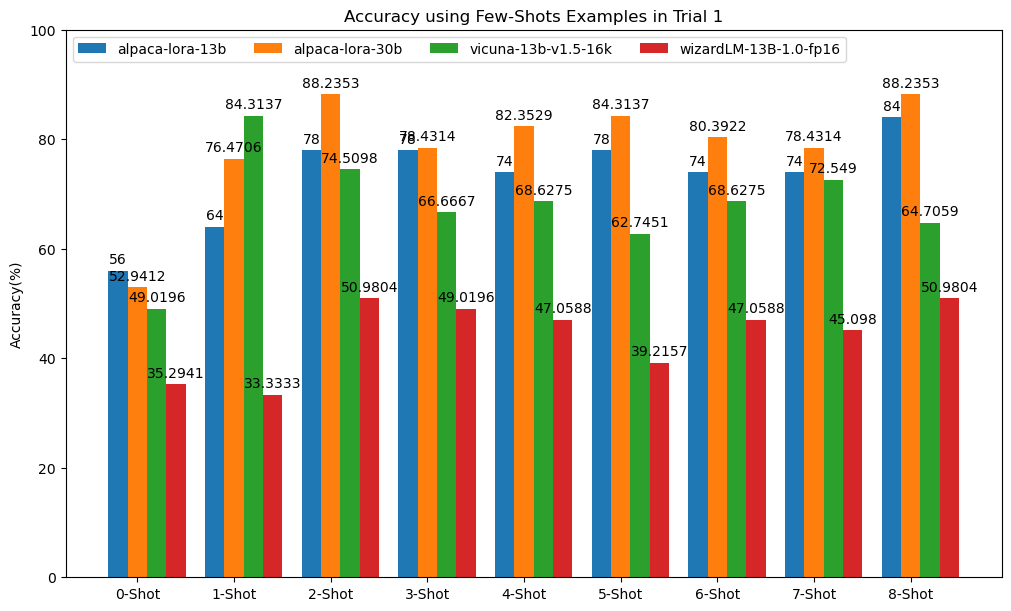

In [68]:
# zero to few shots accuracy chart for each trial
import matplotlib.pyplot as plt

few_shots_examples = [f"{i}-Shot" for i in range(9)]
df_trial_1_inference_performance = df_iter_cot_inference_performance[df_iter_cot_inference_performance["trial-no"] == 1] 
accuracy_stats = {
    inference_performance[1]["model-name"]: [
        inference_performance[1]["iter-cot-answer-0-accuracy"],
        inference_performance[1]["iter-cot-answer-1-accuracy"],
        inference_performance[1]["iter-cot-answer-2-accuracy"],
        inference_performance[1]["iter-cot-answer-3-accuracy"],
        inference_performance[1]["iter-cot-answer-4-accuracy"],
        inference_performance[1]["iter-cot-answer-5-accuracy"],
        inference_performance[1]["iter-cot-answer-6-accuracy"],
        inference_performance[1]["iter-cot-answer-7-accuracy"],
        inference_performance[1]["iter-cot-answer-8-accuracy"]
    ]
for inference_performance in df_trial_1_inference_performance.iterrows()}

x = np.arange(len(few_shots_examples))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10,6))

for attribute, measurement in accuracy_stats.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy(%)')
ax.set_title('Accuracy using Few-Shots Examples in Trial 1')
ax.set_xticks(x + width, few_shots_examples)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 100)

plt.show()

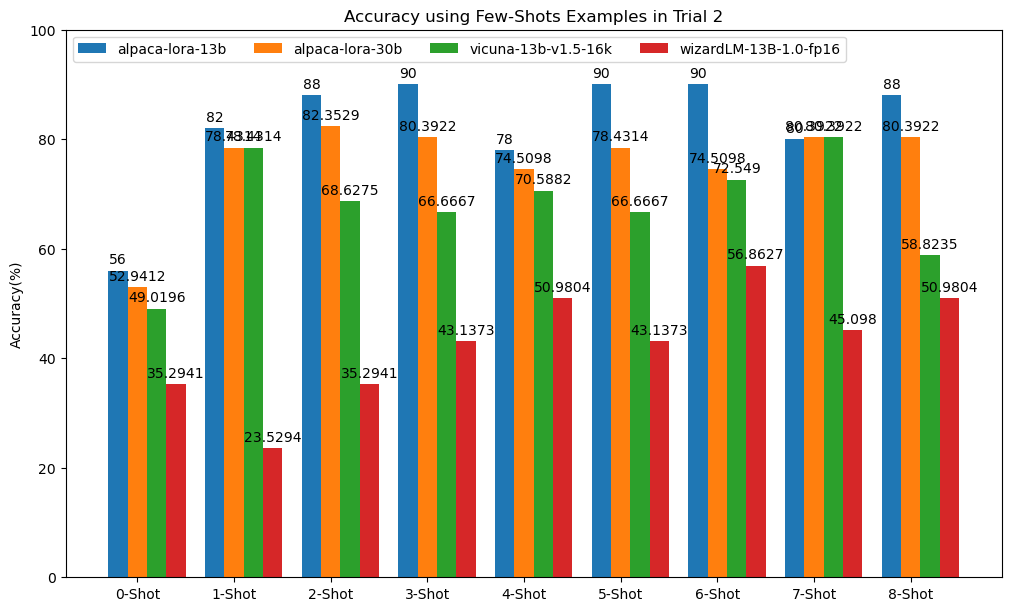

In [72]:
# zero to few shots accuracy chart for each trial
import matplotlib.pyplot as plt

few_shots_examples = [f"{i}-Shot" for i in range(9)]
df_trial_2_inference_performance = df_iter_cot_inference_performance[df_iter_cot_inference_performance["trial-no"] == 2] 
accuracy_stats = {
    inference_performance[1]["model-name"]: [
        inference_performance[1]["iter-cot-answer-0-accuracy"],
        inference_performance[1]["iter-cot-answer-1-accuracy"],
        inference_performance[1]["iter-cot-answer-2-accuracy"],
        inference_performance[1]["iter-cot-answer-3-accuracy"],
        inference_performance[1]["iter-cot-answer-4-accuracy"],
        inference_performance[1]["iter-cot-answer-5-accuracy"],
        inference_performance[1]["iter-cot-answer-6-accuracy"],
        inference_performance[1]["iter-cot-answer-7-accuracy"],
        inference_performance[1]["iter-cot-answer-8-accuracy"]
    ]
for inference_performance in df_trial_2_inference_performance.iterrows()}

x = np.arange(len(few_shots_examples))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10,6))

for attribute, measurement in accuracy_stats.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy(%)')
ax.set_title('Accuracy using Few-Shots Examples in Trial 2')
ax.set_xticks(x + width, few_shots_examples)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 100)

plt.show()

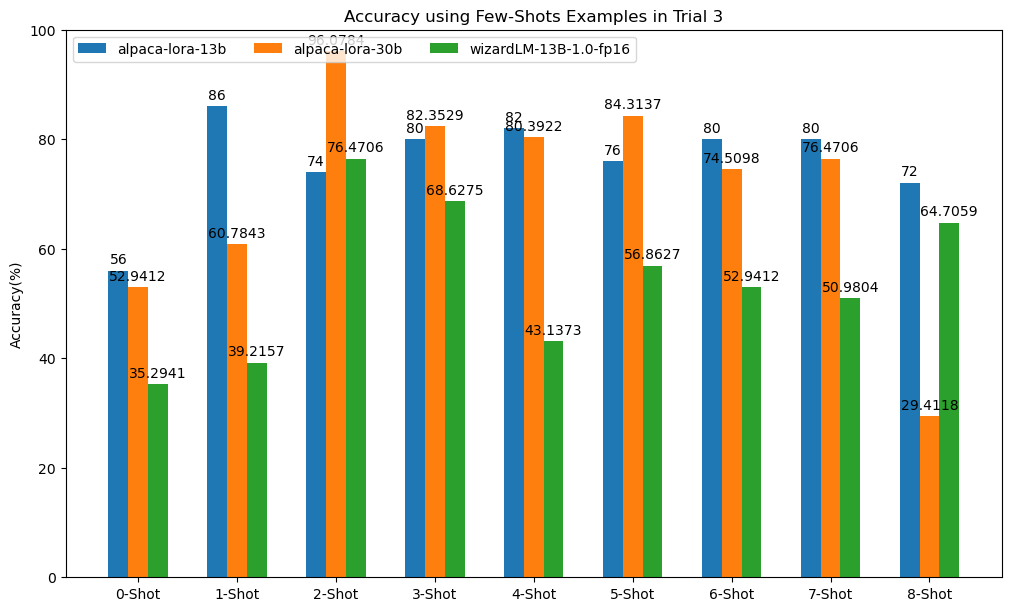

In [73]:
# zero to few shots accuracy chart for each trial
import matplotlib.pyplot as plt

few_shots_examples = [f"{i}-Shot" for i in range(9)]
df_trial_3_inference_performance = df_iter_cot_inference_performance[df_iter_cot_inference_performance["trial-no"] == 3] 
accuracy_stats = {
    inference_performance[1]["model-name"]: [
        inference_performance[1]["iter-cot-answer-0-accuracy"],
        inference_performance[1]["iter-cot-answer-1-accuracy"],
        inference_performance[1]["iter-cot-answer-2-accuracy"],
        inference_performance[1]["iter-cot-answer-3-accuracy"],
        inference_performance[1]["iter-cot-answer-4-accuracy"],
        inference_performance[1]["iter-cot-answer-5-accuracy"],
        inference_performance[1]["iter-cot-answer-6-accuracy"],
        inference_performance[1]["iter-cot-answer-7-accuracy"],
        inference_performance[1]["iter-cot-answer-8-accuracy"]
    ]
for inference_performance in df_trial_3_inference_performance.iterrows()}

x = np.arange(len(few_shots_examples))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10,6))

for attribute, measurement in accuracy_stats.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy(%)')
ax.set_title('Accuracy using Few-Shots Examples in Trial 3')
ax.set_xticks(x + width, few_shots_examples)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 100)

plt.show()

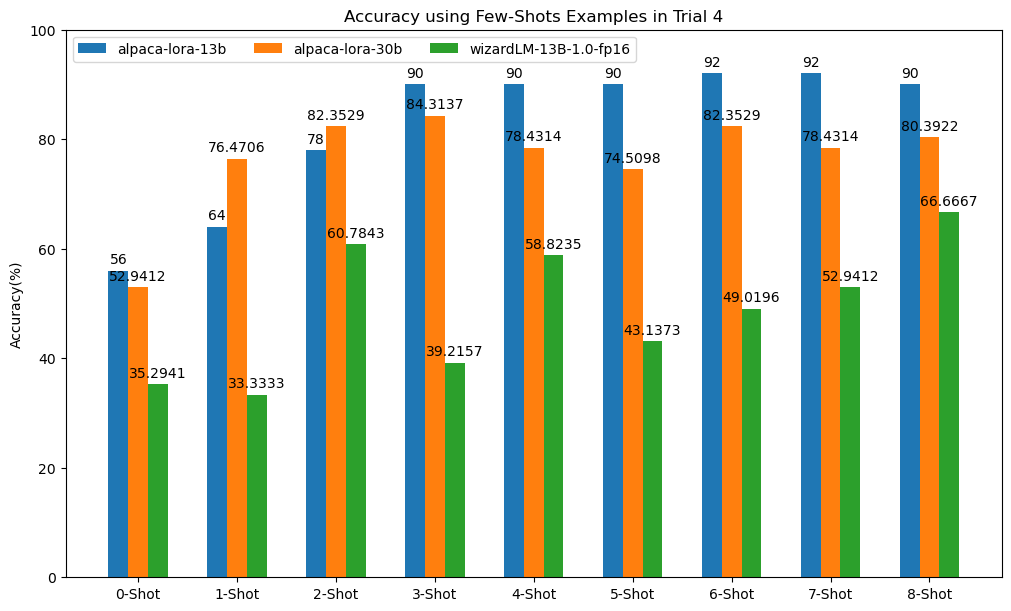

In [74]:
# zero to few shots accuracy chart for each trial
import matplotlib.pyplot as plt

few_shots_examples = [f"{i}-Shot" for i in range(9)]
df_trial_4_inference_performance = df_iter_cot_inference_performance[df_iter_cot_inference_performance["trial-no"] == 4] 
accuracy_stats = {
    inference_performance[1]["model-name"]: [
        inference_performance[1]["iter-cot-answer-0-accuracy"],
        inference_performance[1]["iter-cot-answer-1-accuracy"],
        inference_performance[1]["iter-cot-answer-2-accuracy"],
        inference_performance[1]["iter-cot-answer-3-accuracy"],
        inference_performance[1]["iter-cot-answer-4-accuracy"],
        inference_performance[1]["iter-cot-answer-5-accuracy"],
        inference_performance[1]["iter-cot-answer-6-accuracy"],
        inference_performance[1]["iter-cot-answer-7-accuracy"],
        inference_performance[1]["iter-cot-answer-8-accuracy"]
    ]
for inference_performance in df_trial_4_inference_performance.iterrows()}

x = np.arange(len(few_shots_examples))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10,6))

for attribute, measurement in accuracy_stats.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy(%)')
ax.set_title('Accuracy using Few-Shots Examples in Trial 4')
ax.set_xticks(x + width, few_shots_examples)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 100)

plt.show()

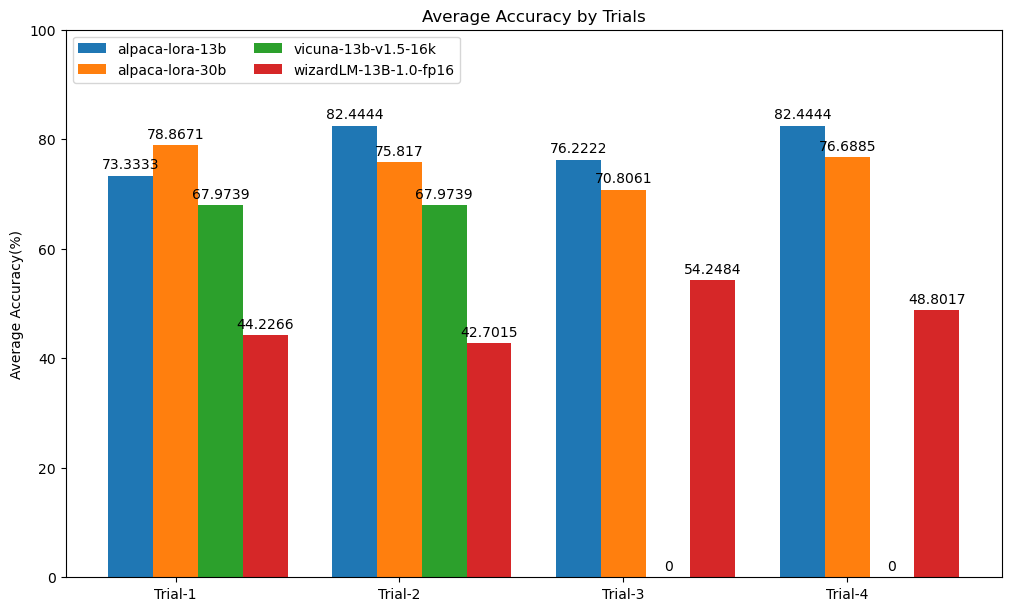

In [61]:
# zero to few shots accuracy chart for each trial
import matplotlib.pyplot as plt

max_trials_in_df = df_iter_cot_inference_performance["trial-no"].max()
trials = [f"Trial-{trial_no}" for trial_no in range(1, max_trials_in_df + 1)]
alpaca_lora_13b = []
alpaca_lora_30b = []
vicuna_13b = []
wizardLM_13b = []
for trial_no in range(1, max_trials_in_df + 1):
    df_alpaca_lora_13b = df_iter_cot_inference_performance[
        (df_iter_cot_inference_performance["dataset-name"] == "StrategyQA") & 
        (df_iter_cot_inference_performance["model-name"] == "alpaca-lora-13b") & 
        (df_iter_cot_inference_performance["trial-no"] == trial_no)
    ]["iter-cot-answer-avg-accuracy"]
    if df_alpaca_lora_13b.empty == True:
        alpaca_lora_13b.append(0.00)
    else:
        alpaca_lora_13b.append(df_alpaca_lora_13b.values[0])

    df_alpaca_lora_30b = df_iter_cot_inference_performance[
        (df_iter_cot_inference_performance["dataset-name"] == "StrategyQA") & 
        (df_iter_cot_inference_performance["model-name"] == "alpaca-lora-30b") & 
        (df_iter_cot_inference_performance["trial-no"] == trial_no)
    ]["iter-cot-answer-avg-accuracy"]
    if df_alpaca_lora_30b.empty == True:
        alpaca_lora_30b.append(0.00)
    else:
        alpaca_lora_30b.append(df_alpaca_lora_30b.values[0])
    
    df_vicuna_13b = df_iter_cot_inference_performance[
        (df_iter_cot_inference_performance["dataset-name"] == "StrategyQA") & 
        (df_iter_cot_inference_performance["model-name"] == "vicuna-13b-v1.5-16k") & 
        (df_iter_cot_inference_performance["trial-no"] == trial_no)
    ]["iter-cot-answer-avg-accuracy"]
    if df_vicuna_13b.empty == True:
        vicuna_13b.append(0.00)
    else:
        vicuna_13b.append(df_vicuna_13b.values[0])
    
    df_wizardLM_13b = df_iter_cot_inference_performance[
        (df_iter_cot_inference_performance["dataset-name"] == "StrategyQA") & 
        (df_iter_cot_inference_performance["model-name"] == "wizardLM-13B-1.0-fp16") & 
        (df_iter_cot_inference_performance["trial-no"] == trial_no)
    ]["iter-cot-answer-avg-accuracy"]
    if df_wizardLM_13b.empty == True:
        wizardLM_13b.append(0.00)
    else:
        wizardLM_13b.append(df_wizardLM_13b.values[0])

accuracy_stats = {
    "alpaca-lora-13b": alpaca_lora_13b,
    "alpaca-lora-30b": alpaca_lora_30b,
    "vicuna-13b-v1.5-16k": vicuna_13b,
    "wizardLM-13B-1.0-fp16": wizardLM_13b
}

x = np.arange(len(trials))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10,6))

for attribute, measurement in accuracy_stats.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Accuracy(%)')
ax.set_title('Average Accuracy by Trials')
ax.set_xticks(x + width, trials)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 100)

plt.show()

In [210]:
filedir = "/kaggle/input/strategyqa-test-dataset-with-llms"
file_name = "iter-cot-inference-performance-v2.csv"
filepath = f"{filedir}/{file_name}"
df_iter_cot_inference_performance_v2 = pd.read_csv(filepath)
df_iter_cot_inference_performance_v2

,dataset-name,model-name,iter-cot-answer-avg-accuracy
0,StrategyQA,alpaca-lora-13b,78.611111
1,StrategyQA,alpaca-lora-30b,75.544662
2,StrategyQA,vicuna-13b-v1.5-16k,67.973856
3,StrategyQA,wizardLM-13B-1.0-fp16,47.494553


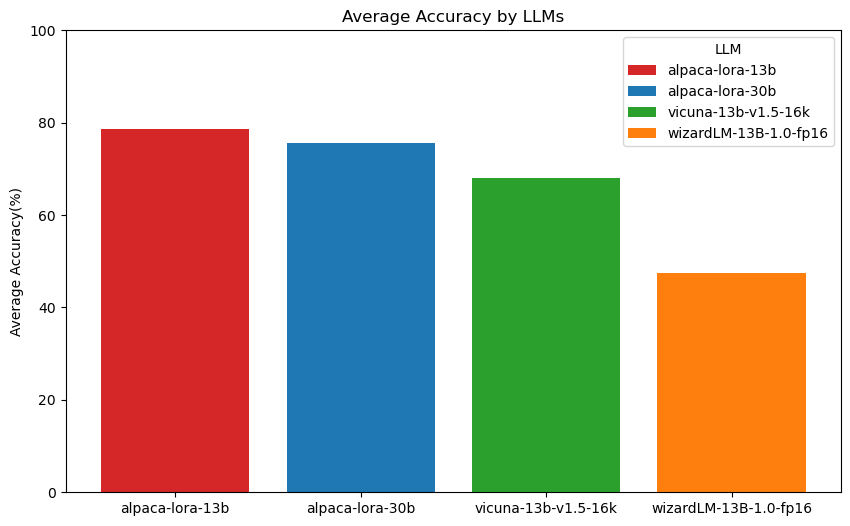

In [214]:
# average accuracy chart for each dataset and llm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6))

model_name = df_iter_cot_inference_performance_v2["model-name"]
average_accuracy = df_iter_cot_inference_performance_v2["iter-cot-answer-avg-accuracy"]
bar_labels = model_name
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']

ax.bar(model_name, average_accuracy, label=bar_labels, color=bar_colors)

ax.set_ylabel('Average Accuracy(%)')
ax.set_title('Average Accuracy by LLMs')
ax.legend(title='LLM')
ax.set_ylim(0, 100)

plt.show()